In [116]:
import pandas as pd
import wandb
import collections
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib
import math

# start less verbose seaborn
import warnings

warnings.filterwarnings("ignore")
# end less verbose seaborn end

# start better plot
import scienceplots

sns.set(font_scale=1.0, rc={"text.usetex": True})
plt.style.use("ieee")
# end better plot

# supress scientific number notation, display only 2  digits after comma
pd.options.display.float_format = '{:.2f}'.format

# Distortion factor is called sigma for all distortions
# in paper, but it is called differently in the imple-
# mentation (sigma, q, factor)
tag_to_val = [
    ("Noise", "sigma"),
    ("Blur", "sigma"),
    ("JPEG", "q"),
    ("Contrast", "factor"),
    ("Rescale", "factor"),
    ("Grid", "factor"),
]
timmname2print = {
    "vit_large_patch16_224": "ViT Large",
    "vit_base_patch16_224": "ViT Base",
    "vit_small_patch16_224": "ViT Small",
    "vit_tiny_patch16_224": "ViT Tiny",
    "tf_efficientnet_b0": "EfficientNet-B0",
    "tf_efficientnet_b1": "EfficientNet-B1",
    "tf_efficientnet_b2": "EfficientNet-B2",
    "tf_efficientnet_b3": "EfficientNet-B3",
    "tf_efficientnet_b4": "EfficientNet-B4",
    "tf_efficientnet_b5": "EfficientNet-B5",
    "tf_efficientnet_b6": "EfficientNet-B6",
    "tf_efficientnet_b7": "EfficientNet-B7",
    "swin_tiny_patch4_window7_224": "Swin Tiny",
    "swin_small_patch4_window7_224": "Swin Small",
    "swin_base_patch4_window7_224": "Swin Base",
    "swin_large_patch4_window7_224": "Swin Large",
    "convnext_atto": "ConvNeXt Atto",
    "convnext_base": "ConvNeXt Base",
    "convnext_femto": "ConvNeXt Femto",
    "convnext_large": "ConvNeXt Large",
    "convnext_nano": "ConvNeXt Nano",
    "convnext_pico": "ConvNeXt Pico",
    "convnext_small": "ConvNeXt Small",
    "convnext_tiny": "ConvNeXt Tiny",
    "convnext_xlarge": "ConvNeXt XLarge",
    "mobilenetv3_small_050": "MobileNetV3 Small 0.50",
    "mobilenetv3_small_075": "MobileNetV3 Small 0.75",
    "mobilenetv3_small_100": "MobileNetV3 Small 1.00",
    "resnet26d": "ResNetD 26",
    "resnet18d": "ResNetD 18",
    "resnet34d": "ResNetD 34",
    "resnet101d": "ResNetD 101",
    "resnet152d": "ResNetD 152",
    "resnet200d": "ResNetD 200",
}

DATACSV = './experiment.csv'

In [4]:
# # Download experiment results from wandb logs.
# # Can be run only once to create experiment.csv
# api = wandb.Api()

# data = collections.defaultdict(list)
# for t_v in tag_to_val:
#     idx = 0
#     runs = api.runs(
#         "petrdvoracek/adversarial",
#         {"$and": [{"group": "advgen_baseline2", "tags": t_v[0]}]},
#     )
#     print(f"Found {len(runs)} runs with distortion {t_v[0]}")

#     for run in runs:
#         # .summary contains the output keys/values for metrics like accuracy.
#         #  We call ._json_dict to omit large files
#         summary = run.summary

#         data["error"].append(summary["eval_error_top1_adv_epoch"])
#         data["params"].append(summary["params"])
#         data["model_name"].append(summary["model_name"])
#         data["base_arch"].append(summary["base_architecture"])
#         data["input_size"].append(summary["input_size"])
#         data["factor"].append(summary[t_v[1]])
#         data["distortion"].append(t_v[0])

# runs_df = pd.DataFrame(data)
# runs_df.to_csv(DATACSV)

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:


Abort: 

In [117]:
df = pd.read_csv(DATACSV, index_col=0)
# print(df.isnull().values.any())

# remove timm pretrained effnet
df = df.drop(
    df[df["model_name"].str.startswith("efficientnet")].index, axis="rows"
)
# remove meaningless data which results in 1.0 error rate
# (if contrast is 0.0 image is totally black)
df = df.drop(
    df[(df["distortion"] == "Contrast") & (df["factor"] == 0.0)].index, axis="rows"
)  
# #remove meaningless data which results in 1.0 error rate
# (if rescale is 0.01 (meaning 100x downscale), images is destroyed too much)
df = df.drop(
    df[(df["distortion"] == "Rescale") & (df["factor"] == 0.01)].index, axis="rows"
)
# rename timm model names to more readable
for k, v in timmname2print.items():
    df = df.replace(k, v)

In [220]:
df["error_min"] = df.groupby("model_name")["error"].transform("min")
df["error_max"] = df.groupby("model_name")["error"].transform("max")
df["error_diff"] = df["error"] - df["error_min"]
# df["error_diff_prec"] = df["error"] / df["error_min"] * 100
df["error_diff_max"] = df["error_max"] - df["error_min"]
df["error_diff_max_perc"] = (df["error_max"] / df["error_min"] * 100).astype(int)
df["error_diff_mean"] = (
    df.groupby("model_name")["error_diff"].transform("sum") / 76
)
# df['model_measurement_count'] = df.groupby('model_name')['error'].count()
# df['error_total_mean'] = df['error_sum'] / 76
# print(df[df['model_name'] == 'EfficientNet-B0'].duplicated(['factor', 'distortion']).sum())

# remove rescale > than 1.0 as this does not affect the accuracy
df = df.drop(df[(df['distortion'] == 'Rescale') & (df['factor'] > 1.0)].index)

# check all models has same number of calculations
model_calc_counts = [x for x in df.groupby("model_name")['error'].count()]
assert all(x == model_calc_counts[0] for x in model_calc_counts), "number of calculations for some  models is not the same"

In [8]:
# print(df.corr(numeric_only=True)["error_diff_mean"])
# plt.figure(figsize=(10, 6))
# sns.scatterplot(data=df, x="params", y="error_total_mean", hue="base_arch", legend=True)

error                  0.39
params                -0.50
input_size            -0.58
factor                -0.00
error_min              0.68
error_max              0.78
error_diff             0.21
error_diff_max         0.15
error_diff_max_perc   -0.63
error_diff_mean        1.00
Name: error_diff_mean, dtype: float64


In [ ]:
df.groupby('distortion').get_group('Blur')[df['model_name'] == 'EfficientNet-B7'].sort_values('error_diff')

In [158]:
asd = df.groupby('distortion').get_group('Rescale')
asd[asd['model_name'] == "ConvNeXt Pico"].sort_values('factor')

,error,params,model_name,base_arch,input_size,factor,distortion,error_min,error_max,error_diff,error_diff_max,error_diff_max_perc,error_diff_mean
2406,0.97,9045672,ConvNeXt Pico,convnext,288,0.05,Rescale,0.20,0.97,0.77,0.77,490,0.21
2405,0.83,9045672,ConvNeXt Pico,convnext,288,0.10,Rescale,0.20,0.97,0.63,0.77,490,0.21
2404,0.54,9045672,ConvNeXt Pico,convnext,288,0.20,Rescale,0.20,0.97,0.35,0.77,490,0.21
2403,0.40,9045672,ConvNeXt Pico,convnext,288,0.30,Rescale,0.20,0.97,0.20,0.77,490,0.21
2402,0.26,9045672,ConvNeXt Pico,convnext,288,0.50,Rescale,0.20,0.97,0.06,0.77,490,0.21
2693,0.26,9045672,ConvNeXt Pico,convnext,288,0.50,Rescale,0.20,0.97,0.06,0.77,490,0.21
2692,0.23,9045672,ConvNeXt Pico,convnext,288,0.60,Rescale,0.20,0.97,0.04,0.77,490,0.21
2691,0.21,9045672,ConvNeXt Pico,convnext,288,0.70,Rescale,0.20,0.97,0.02,0.77,490,0.21
2401,0.21,9045672,ConvNeXt Pico,convnext,288,0.80,Rescale,0.20,0.97,0.01,0.77,490,0.21
2690,0.21,9045672,ConvNeXt Pico,convnext,288,0.80,Rescale,0.20,0.97,0.01,0.77,490,0.21


In [206]:
df.groupby('distortion').get_group('Rescale')['factor']


2440   1.00
2441   0.80
2736   1.20
2737   1.10
2445   0.10
       ... 
2900   0.80
2572   0.20
2573   0.10
2903   0.50
2574   0.05
Name: factor, Length: 578, dtype: float64

In [157]:

asd[asd['model_name'] == "ConvNeXt Nano"].sort_values('factor')

,error,params,model_name,base_arch,input_size,factor,distortion,error_min,error_max,error_diff,error_diff_max,error_diff_max_perc,error_diff_mean
2414,0.96,15593560,ConvNeXt Nano,convnext,288,0.05,Rescale,0.17,0.96,0.79,0.79,560,0.18
2413,0.80,15593560,ConvNeXt Nano,convnext,288,0.10,Rescale,0.17,0.96,0.62,0.79,560,0.18
2412,0.47,15593560,ConvNeXt Nano,convnext,288,0.20,Rescale,0.17,0.96,0.30,0.79,560,0.18
2411,0.33,15593560,ConvNeXt Nano,convnext,288,0.30,Rescale,0.17,0.96,0.16,0.79,560,0.18
2410,0.24,15593560,ConvNeXt Nano,convnext,288,0.50,Rescale,0.17,0.96,0.07,0.79,560,0.18
2703,0.24,15593560,ConvNeXt Nano,convnext,288,0.50,Rescale,0.17,0.96,0.07,0.79,560,0.18
2702,0.21,15593560,ConvNeXt Nano,convnext,288,0.60,Rescale,0.17,0.96,0.04,0.79,560,0.18
2701,0.19,15593560,ConvNeXt Nano,convnext,288,0.70,Rescale,0.17,0.96,0.02,0.79,560,0.18
2409,0.18,15593560,ConvNeXt Nano,convnext,288,0.80,Rescale,0.17,0.96,0.01,0.79,560,0.18
2700,0.18,15593560,ConvNeXt Nano,convnext,288,0.80,Rescale,0.17,0.96,0.01,0.79,560,0.18


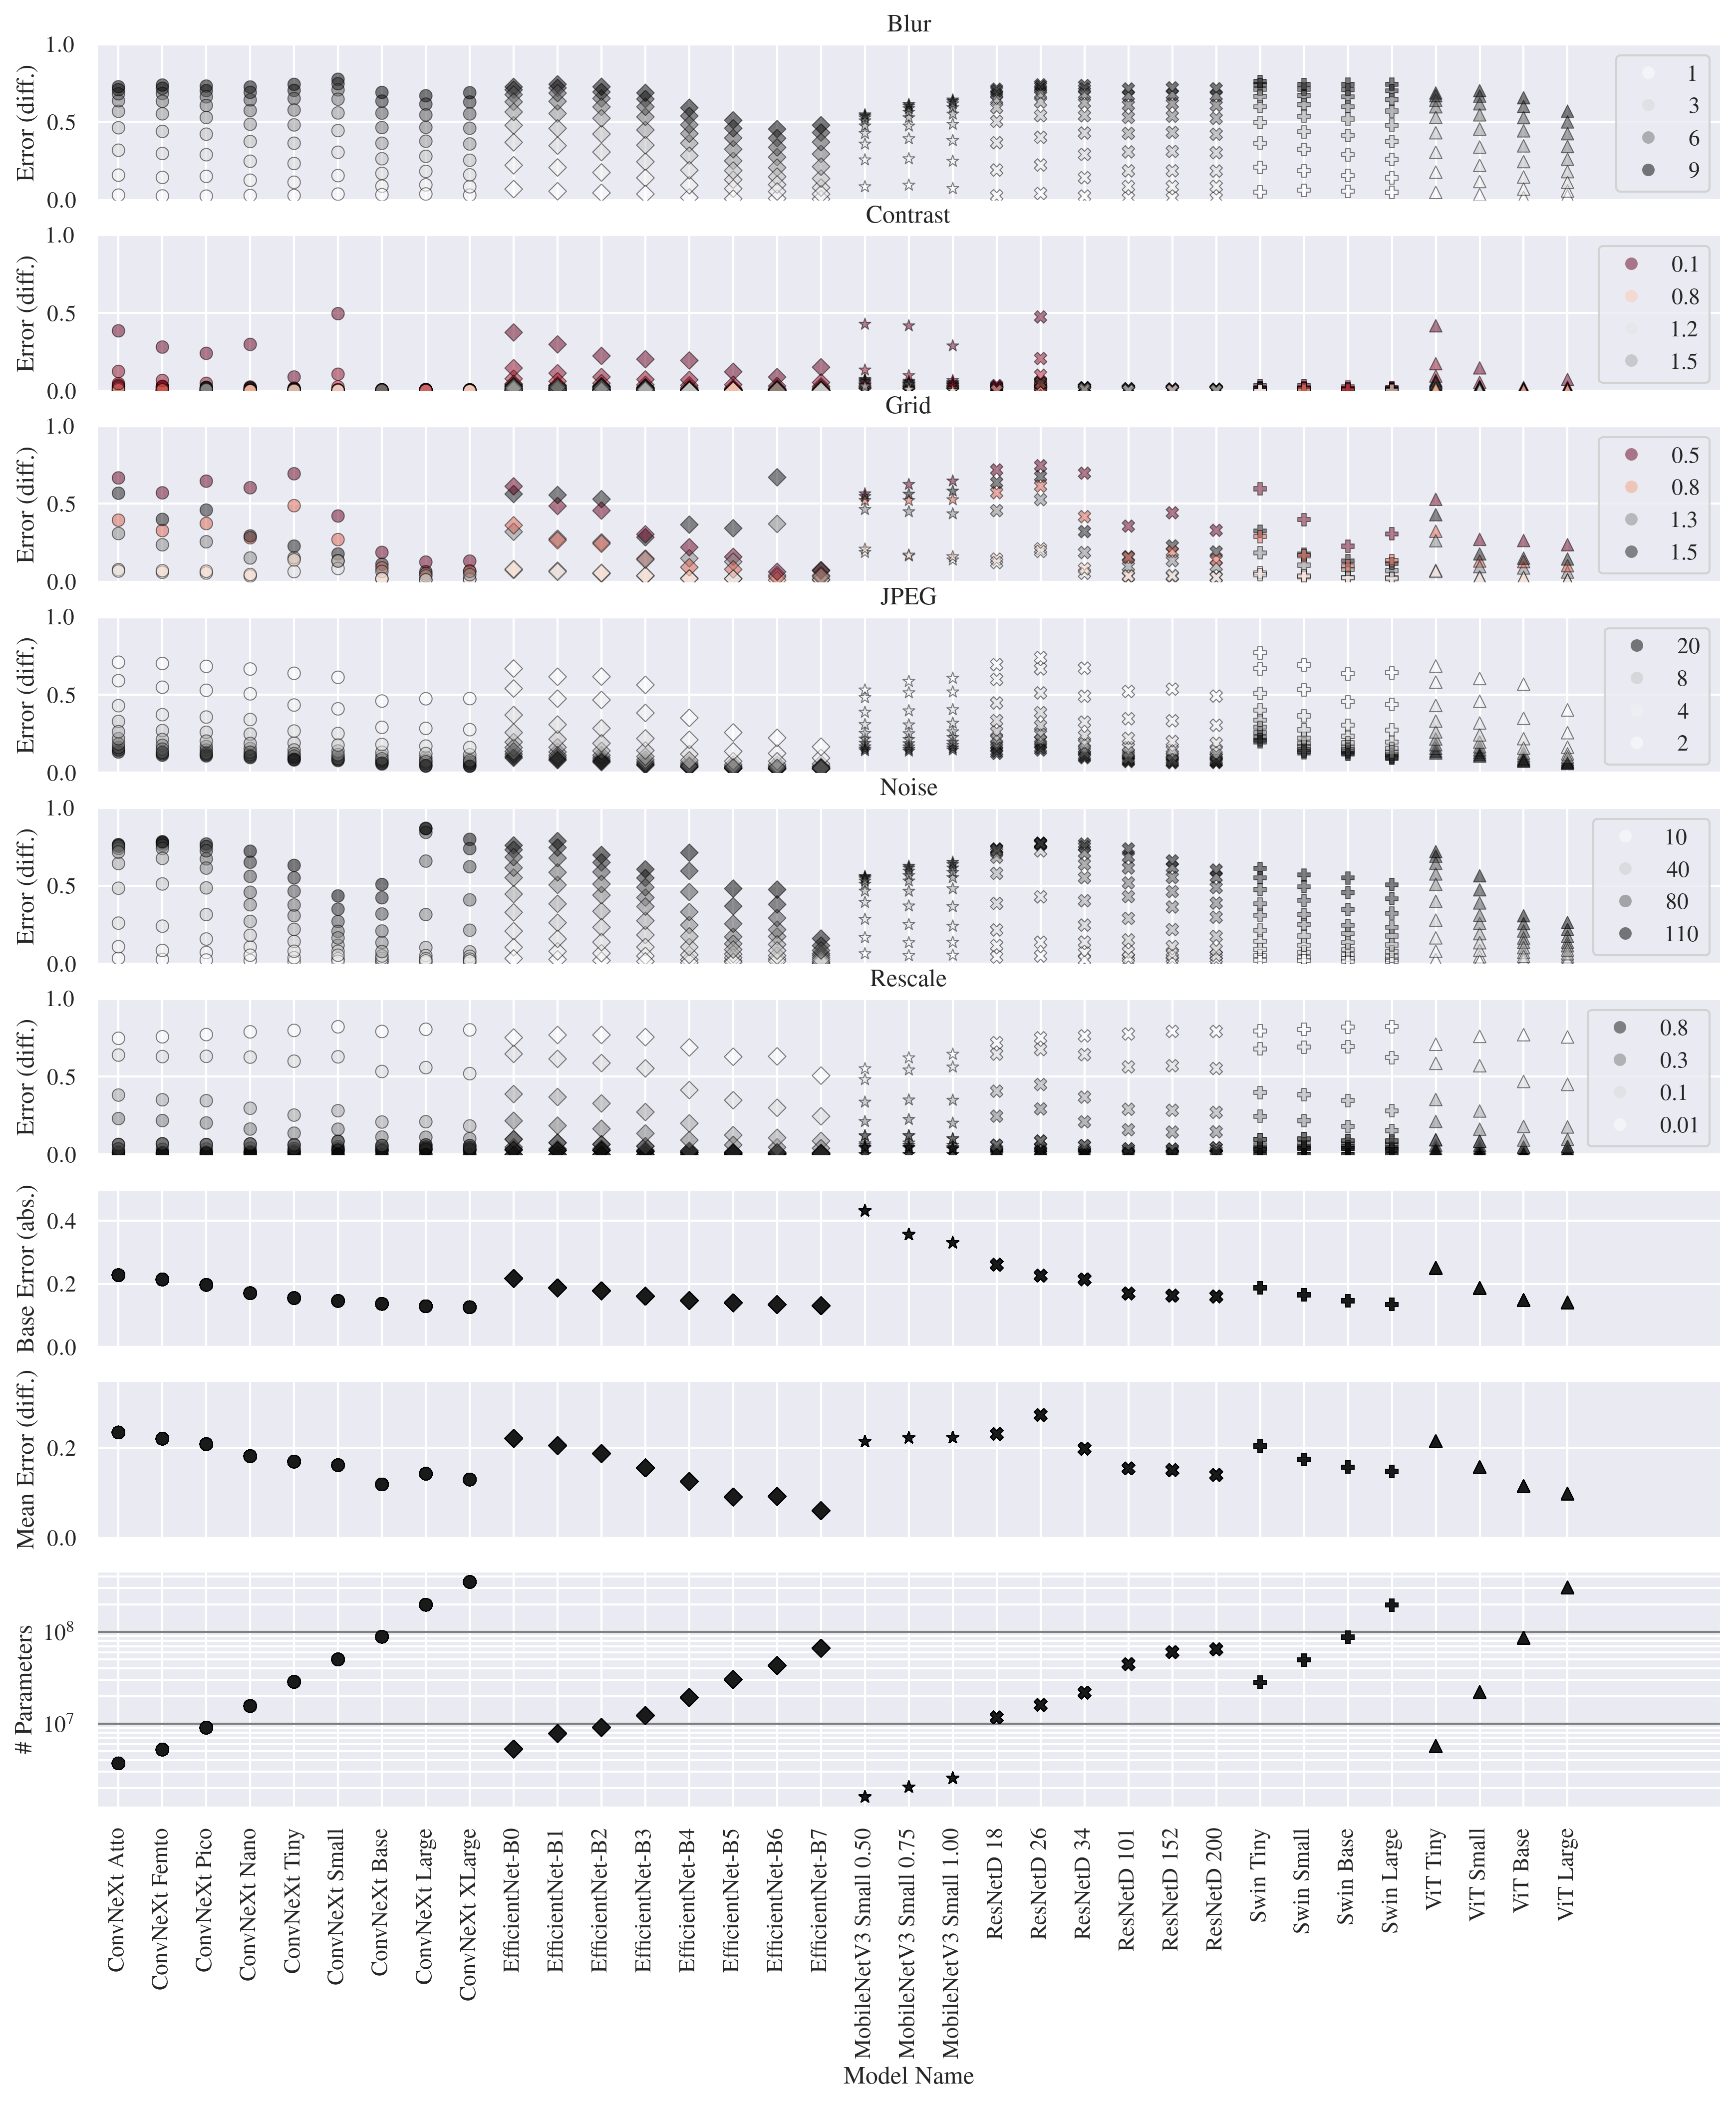

In [268]:
fig, axis = plt.subplots(9, 1, figsize=(14, 1.7 * 9), height_ratios=[1] * 8 + [1.5], dpi=300)
palette_arch = {
    "mobilenetv3": "#0C5DA5",
    "convnext": "#00B945",
    "efficientnet": "#FF9500",
    "vit": "#FF2C00",
    "resnet": "#845B97",
    "swin": "#474747",
}
markers=['o', 'D', '*', 'X', 'P', '^']
# palette_factor = 'Greys'
# sortby = "error_diff_mean" # used in the paper
# sortby = 'params'
# sortby = 'error_min'
sortby = ['base_arch', 'params']
kwargs = dict(edgecolor='black')
for i, ((gname, group), ax) in enumerate(zip(df.groupby("distortion"), axis)):
    group = group.sort_values(by=sortby)
    # print(group.groupby('model_name'))
    if gname == 'Contrast' or gname == 'Grid':
        base_factor = 1.0
        palette_factor = 'RdGy'
    elif gname == 'JPEG':
        base_factor = 100
        palette_factor = 'Greys'
    else:
        base_factor = 0
        palette_factor = 'Greys'

    if gname == 'Rescale':
        norm = matplotlib.colors.LogNorm()
    else:
        norm = plt.Normalize()
    data = group[group["factor"] != base_factor]

    alpha = 0.5
    sns.scatterplot(
        ax=ax,
        data=data,
        # data=group,
        x="model_name",
        y="error_diff",
        hue="factor",
        hue_norm=norm,
        style="base_arch",
        markers=markers,
        # legend=False,
        # palette=["black", (1,0,0,20/255), (1,0,0,60/255), (1,0,0,120/255), (1,0,0,1)],
        palette=palette_factor,
        alpha=alpha,
        # linewidth=2.7,
        **kwargs
    )
    # sns.scatterplot(
    #     ax=ax,
    #     data=group[group["factor"] == base_factor],
    #     x="model_name",
    #     y="error_diff",
    #     hue="factor",
    #     style="base_arch",
    #     legend=False,
    #     # palette=["black", (1,0,0,20/255), (1,0,0,60/255), (1,0,0,120/255), (1,0,0,1)],
    #     palette=['yellow'],
    #     alpha=alpha
    # )

    # This adds individual calculation accuracy as points to the plot
    # sns.stripplot(ax=ax, data=group, x='model_name', y='error', legend=False, hue='factor', alpha=0.7, jitter=False)
    ax.set_title(gname)
    ax.set_ylabel("Error (diff.)")
    ax.set_yticks([0, 0.5, 1.0])
    if i < len(axis) - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Model Name")
        ax.tick_params(axis="x", rotation=90)
    ax.set_ylim(-0.01, 1)
    
    # adjust legend
    # handles, labels = ax.get_legend_handles_labels()
    # print(labels)
    # handles_labels_hue = [
    #     (x, y) for x, y in zip(handles, labels) if y[0] == "$" or y == "1.0"
    # ]
    # handles_hue = [x[0] for x in handles_labels_hue]
    # labels_hue = [x[1] for x in handles_labels_hue]
    # handles_less, labels_less = handles_hue, labels_hue
    # values2show = dct[gname]
    # for v in values2show:
    #     for h, l in zip(handles_hue, labels_hue):
    #         l = l.replace('$\\mathdefault{', '')
    #         l = l.replace('}', '')
    #         l = l.replace('$', '')
    #         v1 = round(float(l), 2)
    #         v2 = round(float(v), 2)
    #         print(v1, v2)
    #         if  v1 == v2:
    #             handles_less.append(h)
    #             labels_less.append(l)

    distortions_legends = {
        "Blur": [1, 3, 6, 9],
        "Contrast": [0.1, 0.8, 1.2, 1.5],
        "Grid": [0.5, 0.8, 1.3, 1.5],
        "JPEG": [20, 8, 4, 2],
        "Noise": [10, 40, 80, 110],
        "Rescale": [4/5, 3/10, 1/10, 1/100],
    }
    handles = []
    if gname == 'Noise':
        norm = plt.Normalize(10, 110)
    elif gname == 'Rescale':
        norm = matplotlib.colors.LogNorm(data['factor'].min(), data['factor'].max())
    else:
        norm = plt.Normalize(data['factor'].min(), data['factor'].max())

    cmap = plt.cm.ScalarMappable(cmap=palette_factor, norm=norm)
    for factor in distortions_legends[gname]:
        handles.append(matplotlib.lines.Line2D([0], [0], color=cmap.to_rgba(factor), label=str(factor), linewidth=0, marker='o', alpha=alpha, markeredgewidth=0))
        ax.legend(handles=handles)
    # lgd = ax.legend(group['factor'], loc="center right", bbox_to_anchor=(1.3, 0.5))
    # fig.artists.append(lgd) # Here's the change
    # fig.colorbar

    

df = df.sort_values(by=sortby)

ax = sns.scatterplot(
    ax=axis[-3],
    data=df,
    x="model_name",
    y="error_min",
    # hue="base_arch",
    style='base_arch',
    markers=markers,
    legend=False,
    palette=palette_arch,
    alpha=0.8,
    **kwargs
)
axis[-3].set_xticklabels([])
axis[-3].set_ylim(0, 0.5)
for c in ax.containers:
    ax.bar_label(c, fmt="%0.3f")
axis[-3].set_ylabel("Base Error (abs.)")
axis[-3].set_xlabel("")


ax = sns.scatterplot(
    ax=axis[-2],
    data=df,
    x="model_name",
    y="error_diff_mean",
    # hue="base_arch",
    style='base_arch',
    markers=markers,
    legend=False,
    palette=palette_arch,
    alpha=0.8,
    **kwargs
)
axis[-2].set_xticklabels([])
axis[-2].set_ylim(0, 0.35)
for c in ax.containers:
    ax.bar_label(c, fmt="%0.3f")
axis[-2].set_ylabel("Mean Error (diff.)")
axis[-2].set_xlabel("")


sns.scatterplot(
    ax=axis[-1],
    data=df,
    x="model_name",
    y="params",
    # hue="base_arch",
    style='base_arch',
    # markers=['o', 's', '+', 'x', 'D', '*'],
    markers=markers,
    # markers= [',', '.', 'o', 'v', '^', '<', '>', '8', 's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X'],
    legend=False,
    palette=palette_arch,
    alpha=0.8,
    **kwargs
)
axis[-1].set_yscale("log")
axis[-1].tick_params(axis="x", rotation=90)
axis[-1].grid(True, which="both", axis="y")
axis[-1].grid(True, which="major", color="gray", axis="y")
axis[-1].set_ylabel("\# Parameters")
axis[-1].set_xlabel("Model Name")

# deal with legends
for ax in axis:
    ax.set_xlim(-0.5, 36.5)
plt.show()

In [172]:
cmap(2)

(0.0, 0.0, 0.3219607843137255, 1.0)

In [92]:
a = group[group['model_name'] == 'MobileNetV3 Small 0.50']
a[a['factor']!=1.0] 

,error,params,model_name,base_arch,input_size,factor,distortion,error_min,error_max,error_diff,error_diff_max,error_diff_max_perc,error_diff_mean
2644,0.45,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,1.40,Rescale,0.43,1.00,0.02,0.56,230,0.22
2649,0.47,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,0.90,Rescale,0.43,1.00,0.04,0.56,230,0.22
2645,0.45,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,1.30,Rescale,0.43,1.00,0.02,0.56,230,0.22
2652,0.50,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,0.60,Rescale,0.43,1.00,0.07,0.56,230,0.22
2653,0.55,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,0.50,Rescale,0.43,1.00,0.12,0.56,230,0.22
2651,0.49,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,0.70,Rescale,0.43,1.00,0.06,0.56,230,0.22
2650,0.48,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,0.80,Rescale,0.43,1.00,0.05,0.56,230,0.22
2647,0.46,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,1.10,Rescale,0.43,1.00,0.03,0.56,230,0.22
2646,0.46,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,1.20,Rescale,0.43,1.00,0.03,0.56,230,0.22
2369,0.48,1593224,MobileNetV3 Small 0.50,mobilenetv3,224,0.80,Rescale,0.43,1.00,0.05,0.56,230,0.22


1.5 1.0
3.0 1.0
4.5 1.0
6.0 1.0
7.5 1.0
9.0 1.0
1.5 3.0
3.0 3.0
4.5 3.0
6.0 3.0
7.5 3.0
9.0 3.0
1.5 6.0
3.0 6.0
4.5 6.0
6.0 6.0
7.5 6.0
9.0 6.0
1.5 9.0
3.0 9.0
4.5 9.0
6.0 9.0
7.5 9.0
9.0 9.0
['$\\mathdefault{1.5}$', '$\\mathdefault{3.0}$', '$\\mathdefault{4.5}$', '$\\mathdefault{6.0}$', '$\\mathdefault{7.5}$', '$\\mathdefault{9.0}$']
0.4 0.1
0.8 0.1
1.2 0.1
1.6 0.1
2.0 0.1
0.4 0.8
0.8 0.8
1.2 0.8
1.6 0.8
2.0 0.8
0.4 1.2
0.8 1.2
1.2 1.2
1.6 1.2
2.0 1.2
0.4 1.5
0.8 1.5
1.2 1.5
1.6 1.5
2.0 1.5
['$\\mathdefault{0.4}$', '$\\mathdefault{0.8}$', '$\\mathdefault{1.2}$', '$\\mathdefault{1.6}$', '$\\mathdefault{2.0}$']
0.6 0.5
0.8 0.5
1.0 0.5
1.2 0.5
1.4 0.5
0.6 0.8
0.8 0.8
1.0 0.8
1.2 0.8
1.4 0.8
0.6 1.3
0.8 1.3
1.0 1.3
1.2 1.3
1.4 1.3
0.6 1.5
0.8 1.5
1.0 1.5
1.2 1.5
1.4 1.5
['$\\mathdefault{0.6}$', '$\\mathdefault{0.8}$', '$\\mathdefault{1.0}$', '$\\mathdefault{1.2}$', '$\\mathdefault{1.4}$']
3.0 20.0
6.0 20.0
9.0 20.0
12.0 20.0
15.0 20.0
18.0 20.0
3.0 8.0
6.0 8.0
9.0 8.0
12.0 8.0
15.0 8.0
18

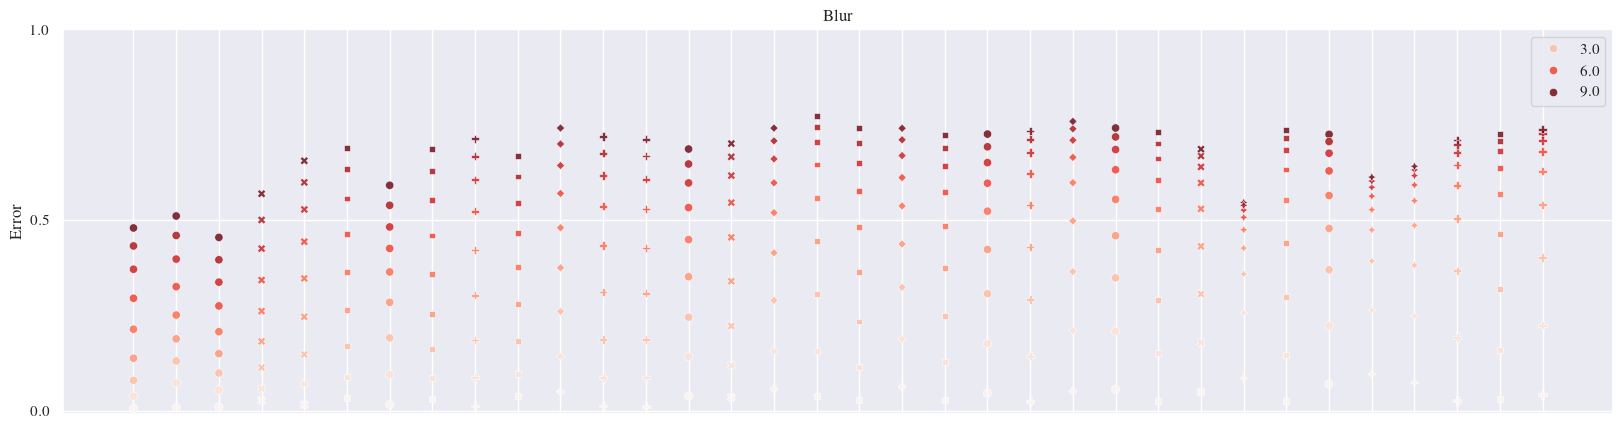

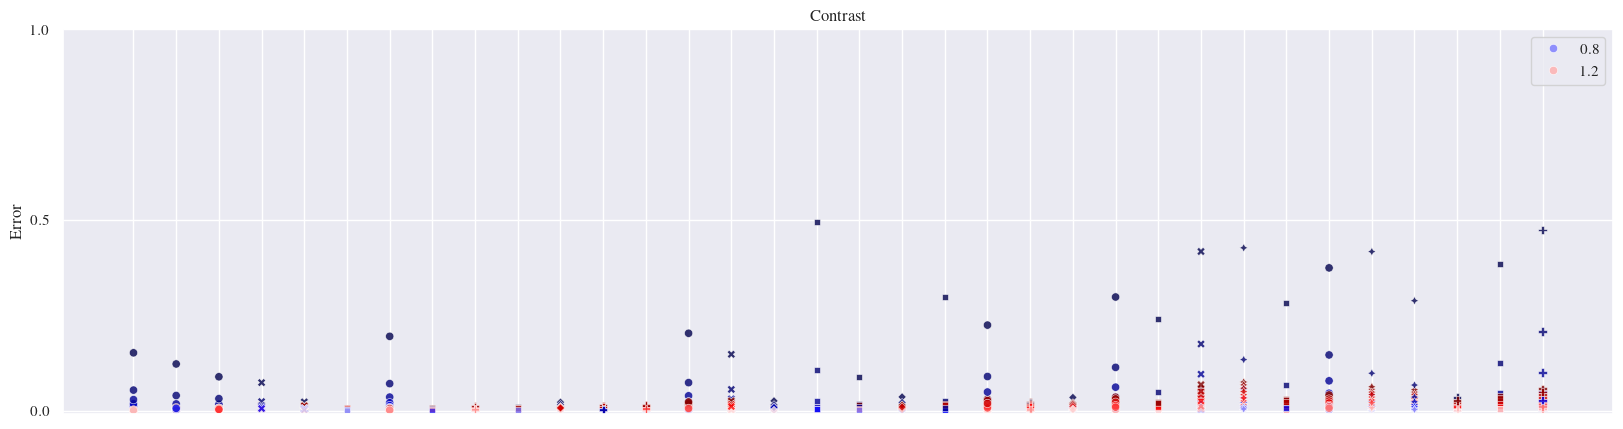

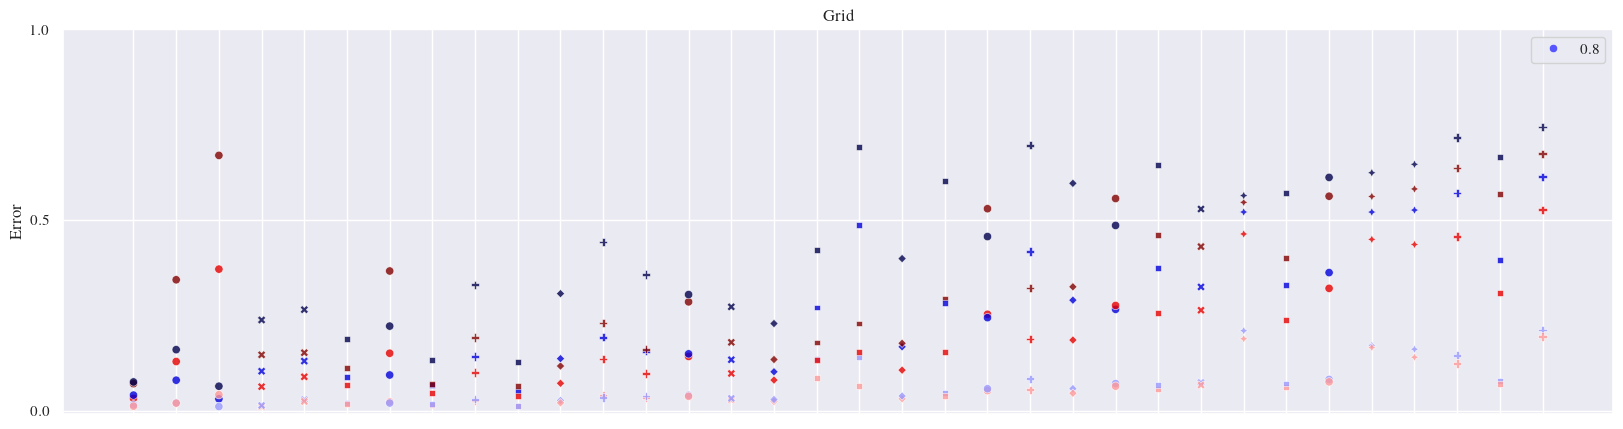

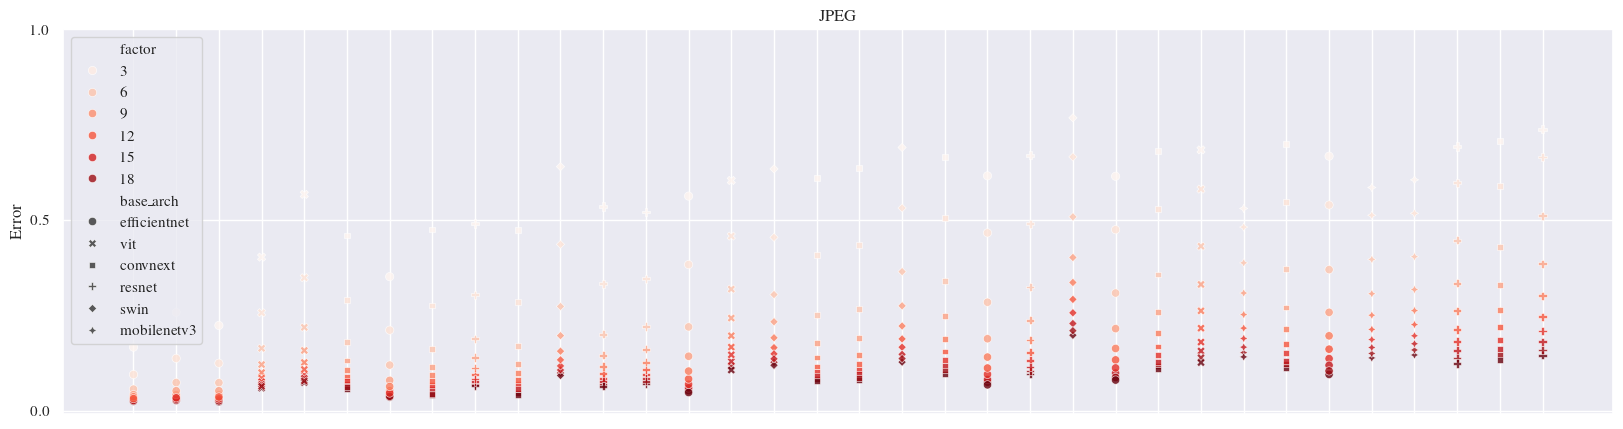

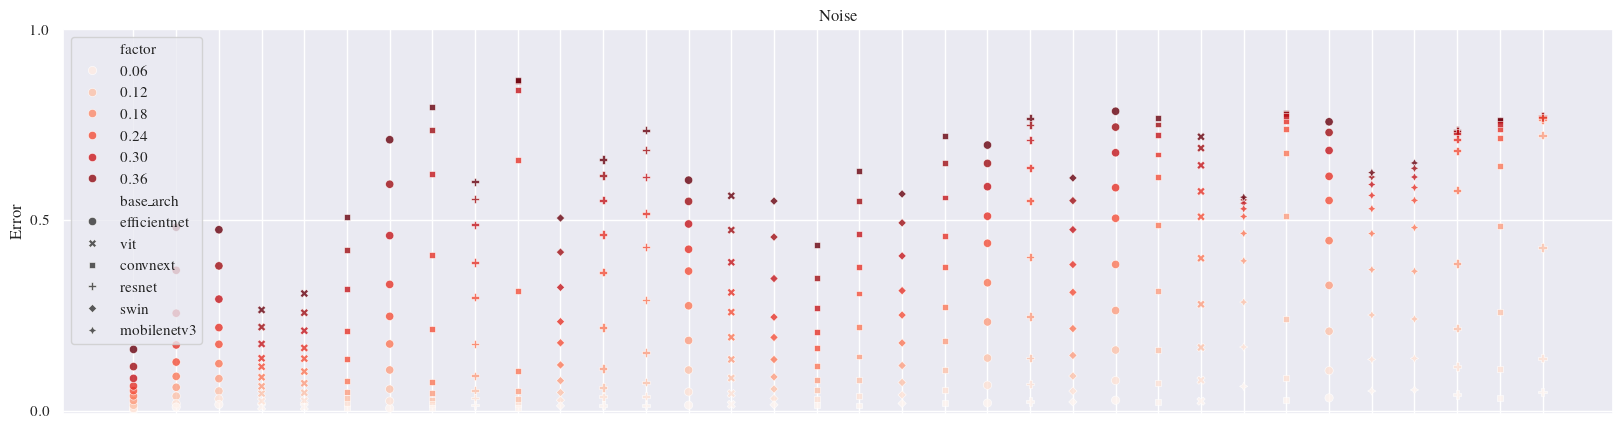

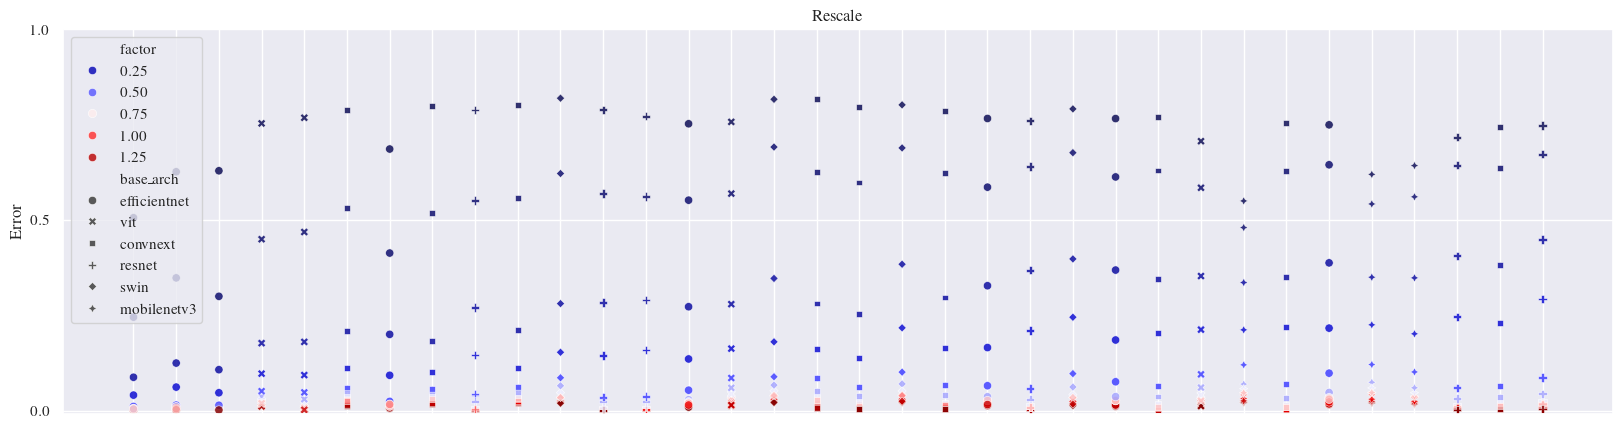

In [115]:
palette = {
    "mobilenetv3": "#0C5DA5",
    "convnext": "#00B945",
    "efficientnet": "#FF9500",
    "vit": "#FF2C00",
    "resnet": "#845B97",
    "swin": "#474747",
}
sortby = "error_diff_mean"  # used in the paper
# sortby = 'params'
# sortby = 'error_min'
# sortby = ['base_arch', 'params']
for i, (gname, group) in enumerate(df.groupby("distortion")):
    group = group.sort_values(by=sortby)
    # print(group.groupby('model_name'))
    if gname == "Contrast" or gname == "Grid" or gname == "Rescale":
        base_factor = 1.0
        palette = "seismic"
    elif gname == "JPEG":
        base_factor = 100
        palette = "Reds"
        vmin, vmax = 2, 20
    else:
        base_factor = 0
        palette = "Reds"
    alpha = 0.8
    cmap = plt.get_cmap(palette)

    fig, ax = plt.subplots(1, 1, figsize=(20, 5), dpi=100)
    sns.scatterplot(
        ax=ax,
        data=group[group["factor"] != base_factor],
        x="model_name",
        y="error_diff",
        hue="factor",
        style="base_arch",
        legend="brief",
        # palette=["black", (1,0,0,20/255), (1,0,0,60/255), (1,0,0,120/255), (1,0,0,1)],
        palette=palette,
        alpha=alpha,
    )
    # print(group["factor"].unique())
    # sns.scatterplot(
    #     ax=ax,
    #     data=group[group["factor"] == base_factor],
    #     x="model_name",
    #     y="error_diff",
    #     hue="factor",
    #     style="base_arch",
    #     legend='brief',
    #     # palette=["black", (1,0,0,20/255), (1,0,0,60/255), (1,0,0,120/255), (1,0,0,1)],
    #     palette=['yellow'],
    #     alpha=alpha
    # )

    # # Add colorbar next to each plot
    # norm = plt.Normalize(df['factor'].min(), df['factor'].max())
    # sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    # sm.set_array([])
    # fig.colorbar(sm, ax=ax)

    # blue_line = matplotlib.lines.mlines.Line2D([], [], color='blue', marker='o',
    #                       markersize=15, label='Blue stars', linestyle='')
    # ax.legend(handles=[blue_line])

    # This adds individual calculation accuracy as points to the plot
    # sns.stripplot(ax=ax, data=group, x='model_name', y='error', legend=False, hue='factor', alpha=0.7, jitter=False)
    ax.set_title(gname)
    ax.set_ylabel("Error")
    ax.set_yticks([0, 0.5, 1.0])
    if i < len(axis) - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Model Name")
        ax.tick_params(axis="x", rotation=90)
    ax.set_ylim(-0.01, 1)
    # lgd = ax.legend(group['factor'], loc="center right", bbox_to_anchor=(1.3, 0.5))
    # fig.artists.append(lgd) # Here's the change
    # fig.colorbar
    # Add legend for hue only

    # norm = plt.Normalize(df['factor'].min(), df['factor'].max())
    # sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    # sm.set_array([])
    # fig.colorbar(sm, ax=ax)
    dct = {
        "Blur": [1, 3, 6, 9],
        "Contrast": [0.1, 0.8, 1.2, 1.5],
        "Grid": [0.5, 0.8, 1.3, 1.5],
        "JPEG": [20, 8, 4, 2],
        "Noise": [10/255, 40/255, 80/255, 110/255],
        "Rescale": [3/10, 1/10, 5/100, 1/100],
    }

    handles, labels = ax.get_legend_handles_labels()
    handles_labels_hue = [
        (x, y) for x, y in zip(handles, labels) if y[0] == "$" or y == "1.0"
    ]
    handles_hue = [x[0] for x in handles_labels_hue]
    labels_hue = [x[1] for x in handles_labels_hue]
    handles_less, labels_less = [], []
    values2show = dct[gname]
    for v in values2show:
        for h, l in zip(handles_hue, labels_hue):
            l = l.replace('$\\mathdefault{', '')
            l = l.replace('}', '')
            l = l.replace('$', '')
            v1 = round(float(l), 2)
            v2 = round(float(v), 2)
            print(v1, v2)
            if  v1 == v2:
                handles_less.append(h)
                labels_less.append(l)

    print(labels_hue)
    ax.legend(handles=handles_less, labels=labels_less)

# df = df.sort_values(by=sortby)

# ax = sns.scatterplot(
#     ax=axis[-3],
#     data=df,
#     x="model_name",
#     y="error_min",
#     hue="base_arch",
#     legend=False,
#     palette=palette,
#     alpha=0.8,
# )
# axis[-3].set_xticklabels([])
# axis[-3].set_ylim(0, 0.5)
# for c in ax.containers:
#     ax.bar_label(c, fmt="%0.3f")
# axis[-3].set_ylabel("Base Error")
# axis[-3].set_xlabel("")


# ax = sns.scatterplot(
#     ax=axis[-2],
#     data=df,
#     x="model_name",
#     y="error_diff_mean",
#     hue="base_arch",
#     legend=False,
#     palette=palette,
#     alpha=0.8,
# )
# axis[-2].set_xticklabels([])
# axis[-2].set_ylim(0, 0.35)
# for c in ax.containers:
#     ax.bar_label(c, fmt="%0.3f")
# axis[-2].set_ylabel("Mean Error")
# axis[-2].set_xlabel("")


# sns.scatterplot(
#     ax=axis[-1],
#     data=df,
#     x="model_name",
#     y="params",
#     hue="base_arch",
#     legend=False,
#     palette=palette,
#     alpha=0.8,
# )
# axis[-1].set_yscale("log")
# axis[-1].tick_params(axis="x", rotation=90)
# axis[-1].grid(True, which="both", axis="y")
# axis[-1].grid(True, which="major", color="gray", axis="y")
# axis[-1].set_ylabel("\# Parameters")
# axis[-1].set_xlabel("Model Name")
# plt.show()

In [81]:
ax.get_cmap

AttributeError: 'Axes' object has no attribute 'get_cmap'

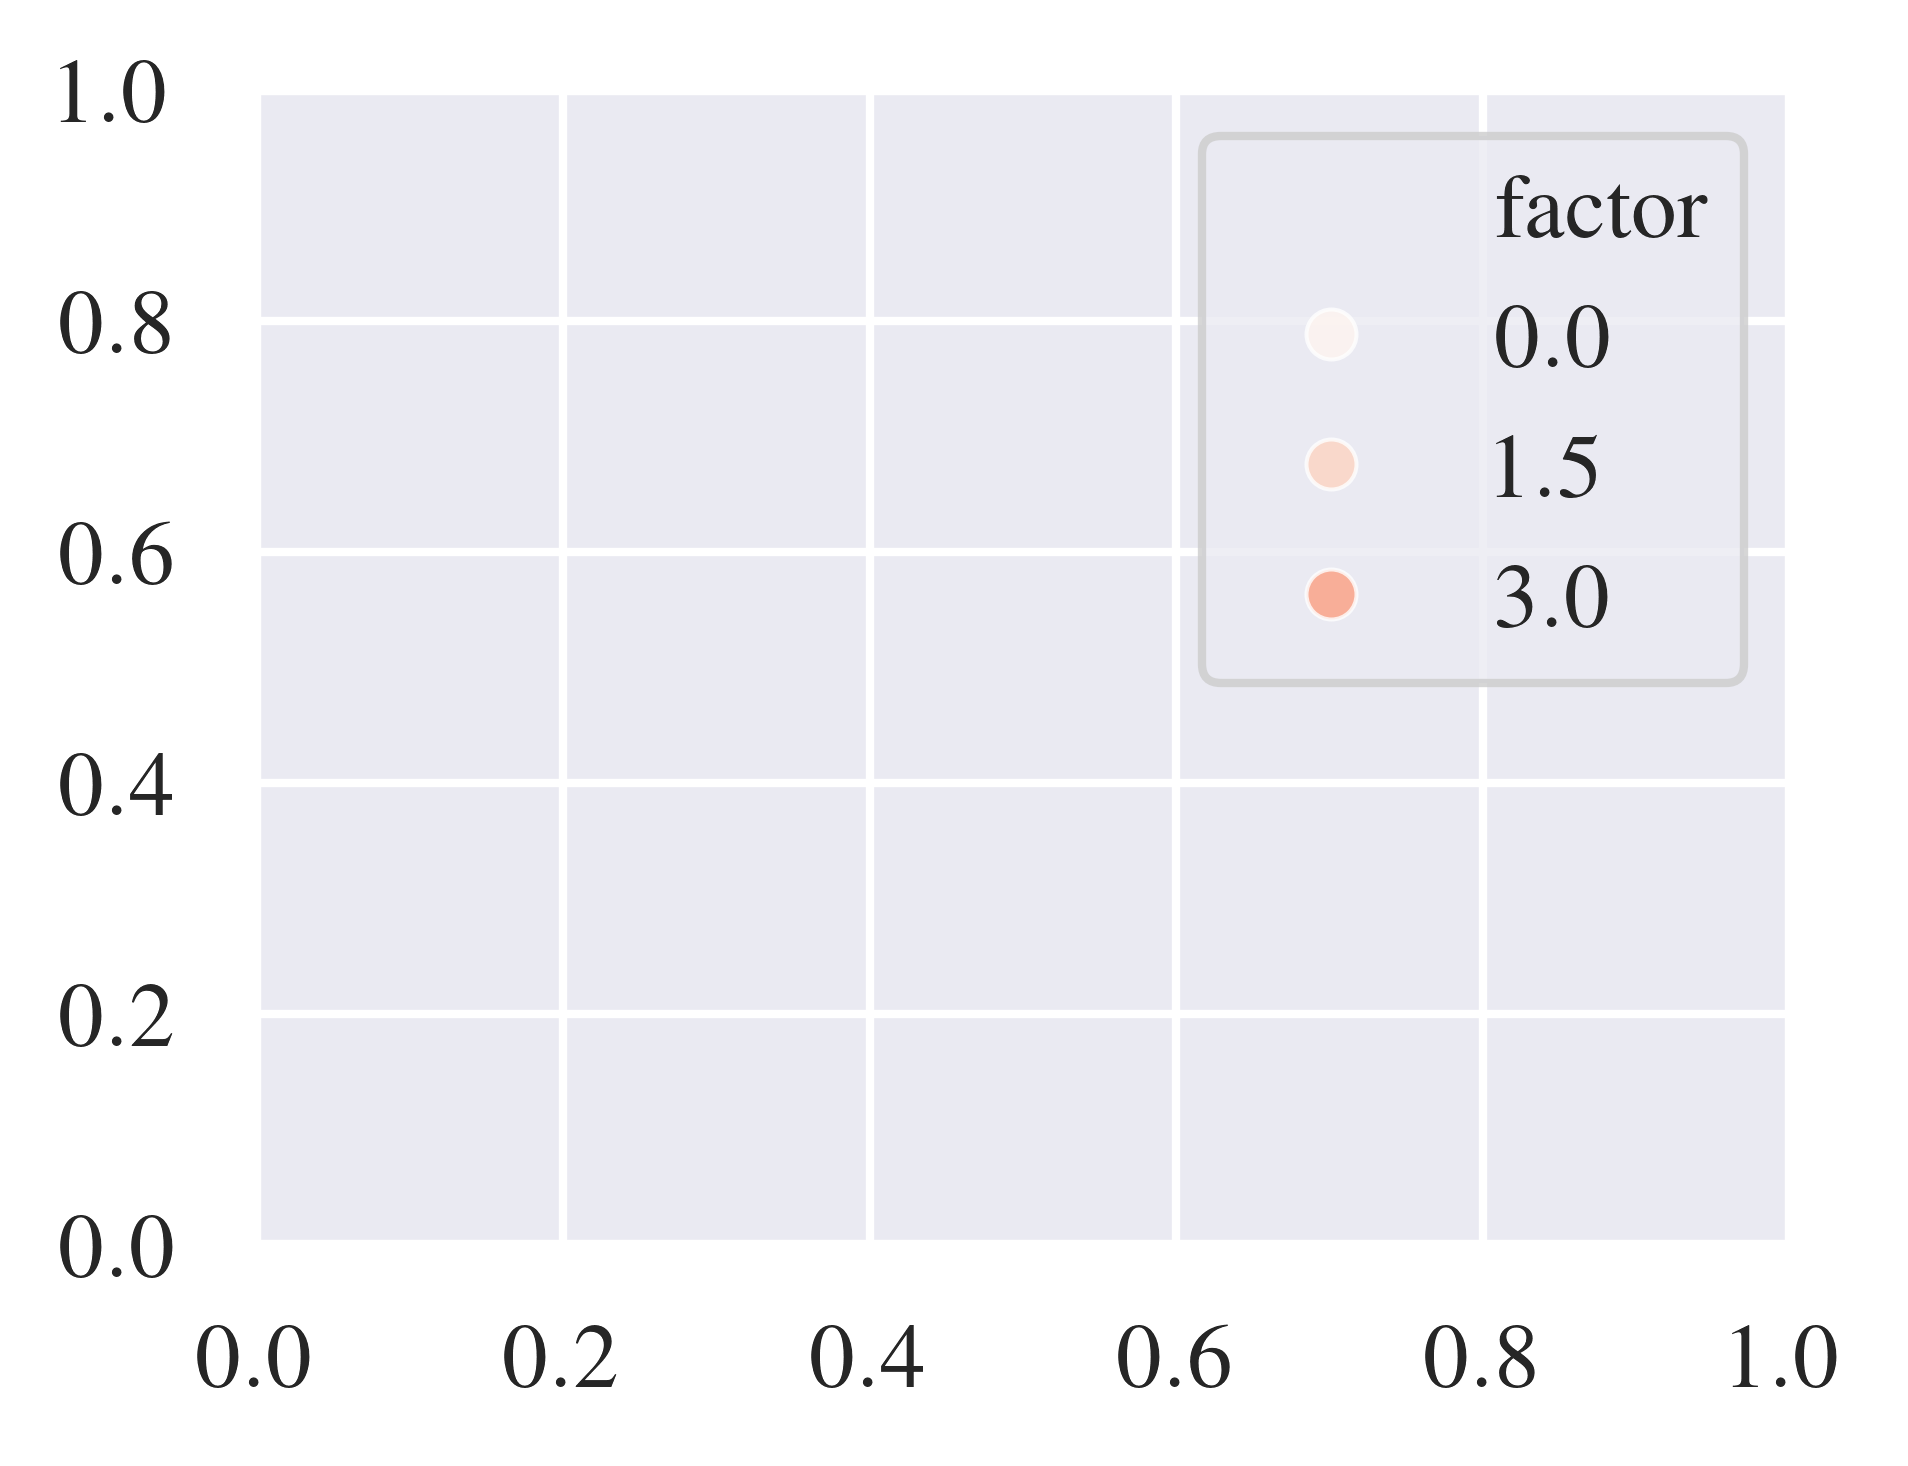

In [73]:
import matplotlib.lines as mlines

fig, ax = plt.subplots()
ax.legend(handles=handles[:4], labels=labels[:4])

plt.show()

In [71]:
ax.get_legend_handles_labels()

([<matplotlib.lines.Line2D at 0x7f48da2aeb30>,
 ['factor',
  '$\\mathdefault{0.0}$',
  '$\\mathdefault{1.5}$',
  '$\\mathdefault{3.0}$',
  '$\\mathdefault{4.5}$',
  '$\\mathdefault{6.0}$',
  '$\\mathdefault{7.5}$',
  '$\\mathdefault{9.0}$',
  'base_arch',
  'efficientnet',
  'vit',
  'convnext',
  'resnet',
  'swin',
  'mobilenetv3',
  'factor',
  '0.0',
  'base_arch',
  'efficientnet',
  'vit',
  'convnext',
  'resnet',
  'swin',
  'mobilenetv3'])

In [45]:
ax.get_legend().get_handles()

AttributeError: 'Legend' object has no attribute 'get_handles'

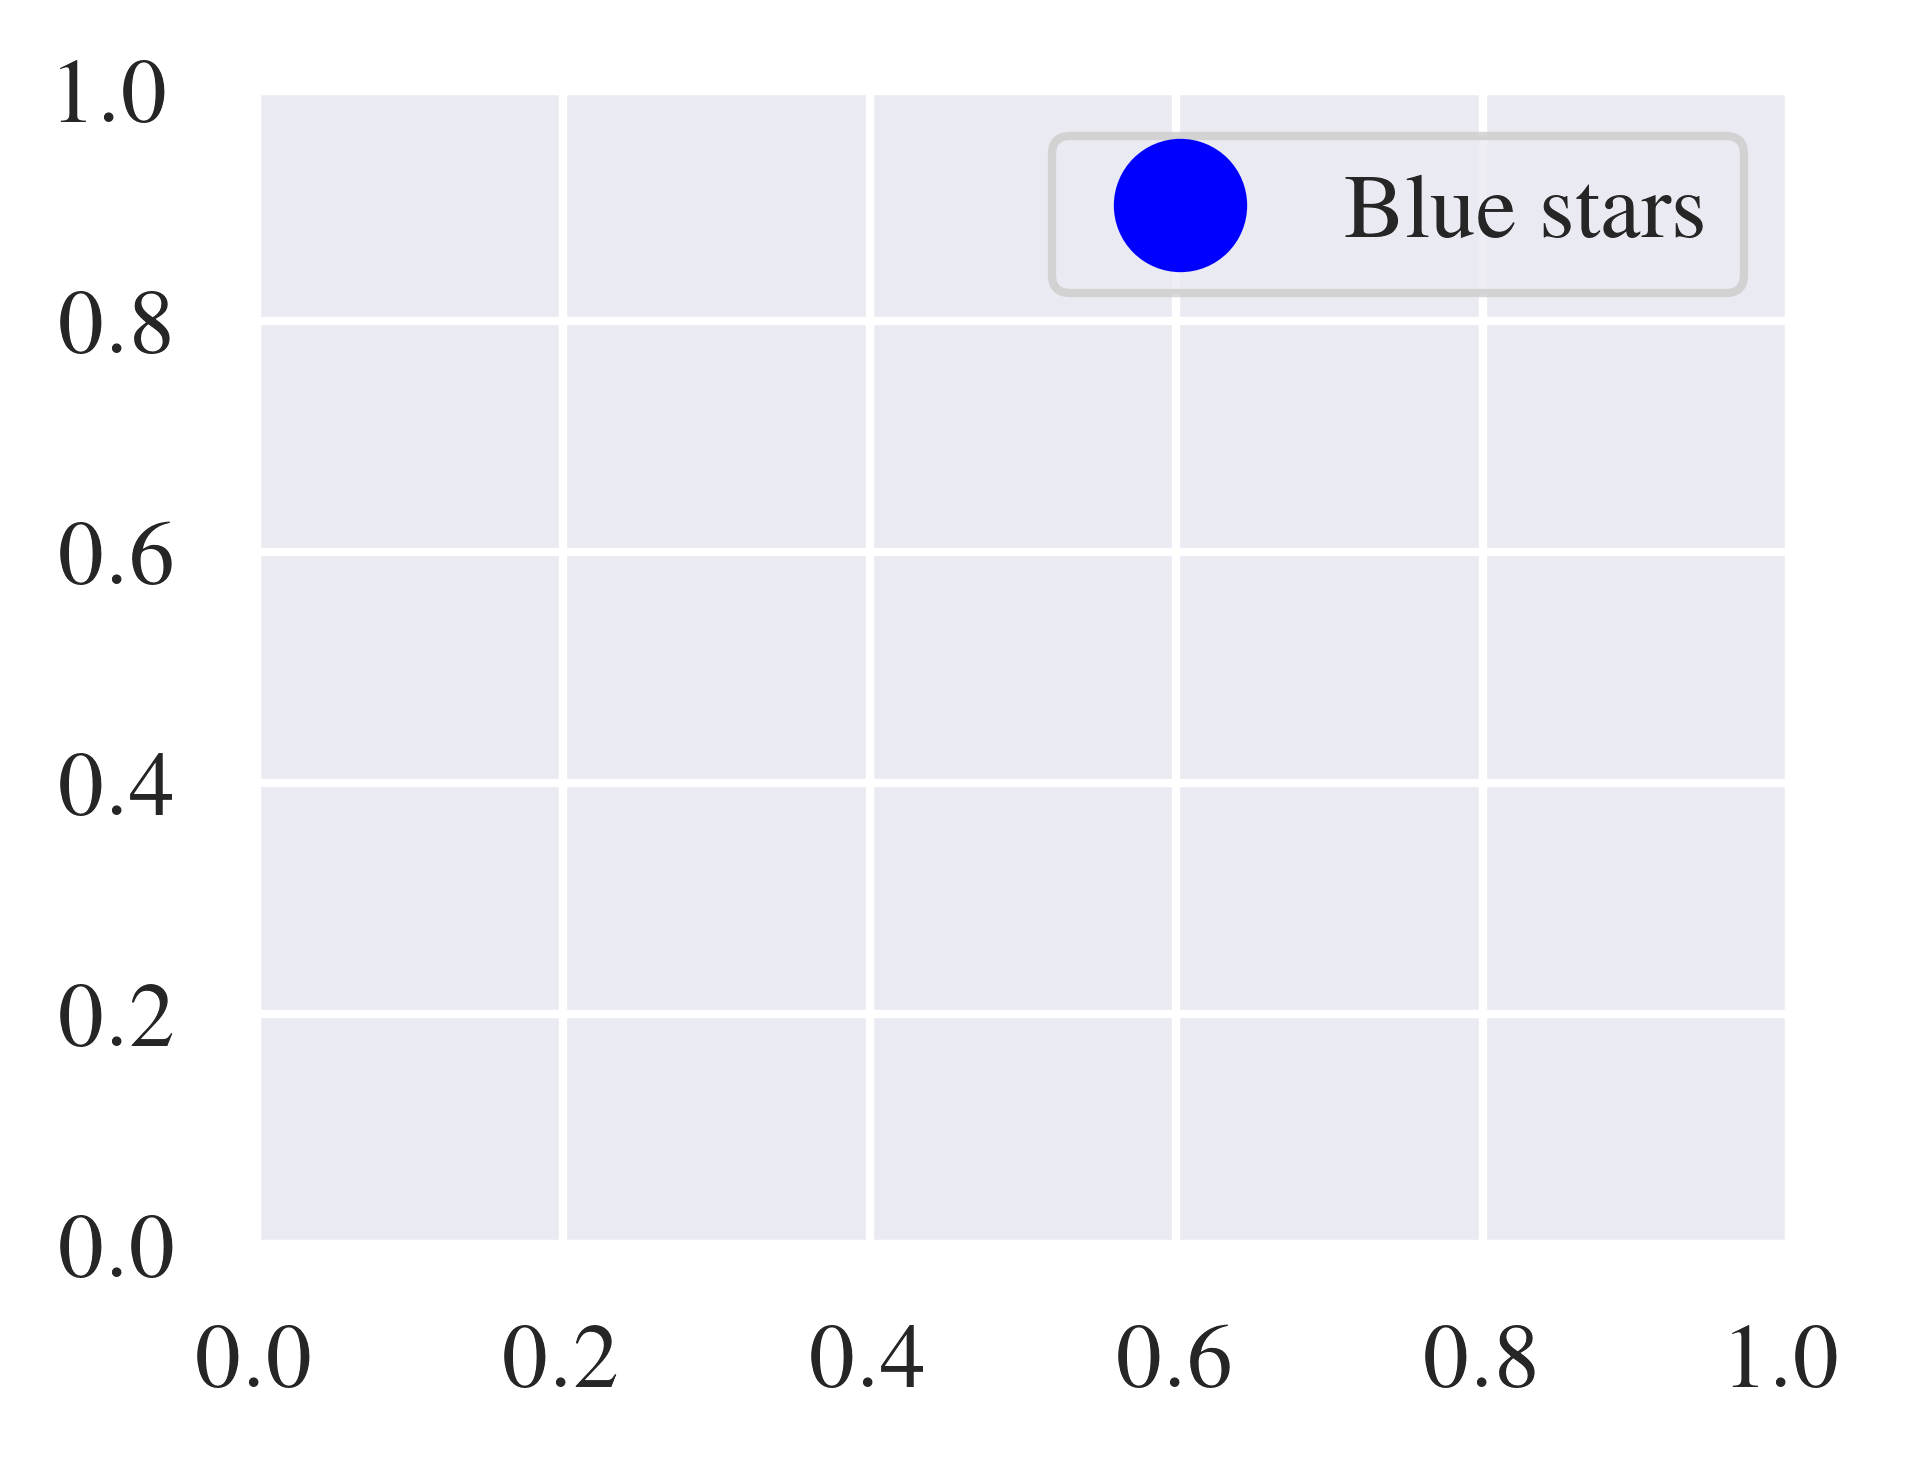

In [39]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

fig, ax = plt.subplots()
blue_line = mlines.Line2D([], [], color='blue', marker='o',
                          markersize=15, label='Blue stars', linestyle='')
ax.legend(handles=[blue_line])

plt.show()

KeyError: 'Distortion'

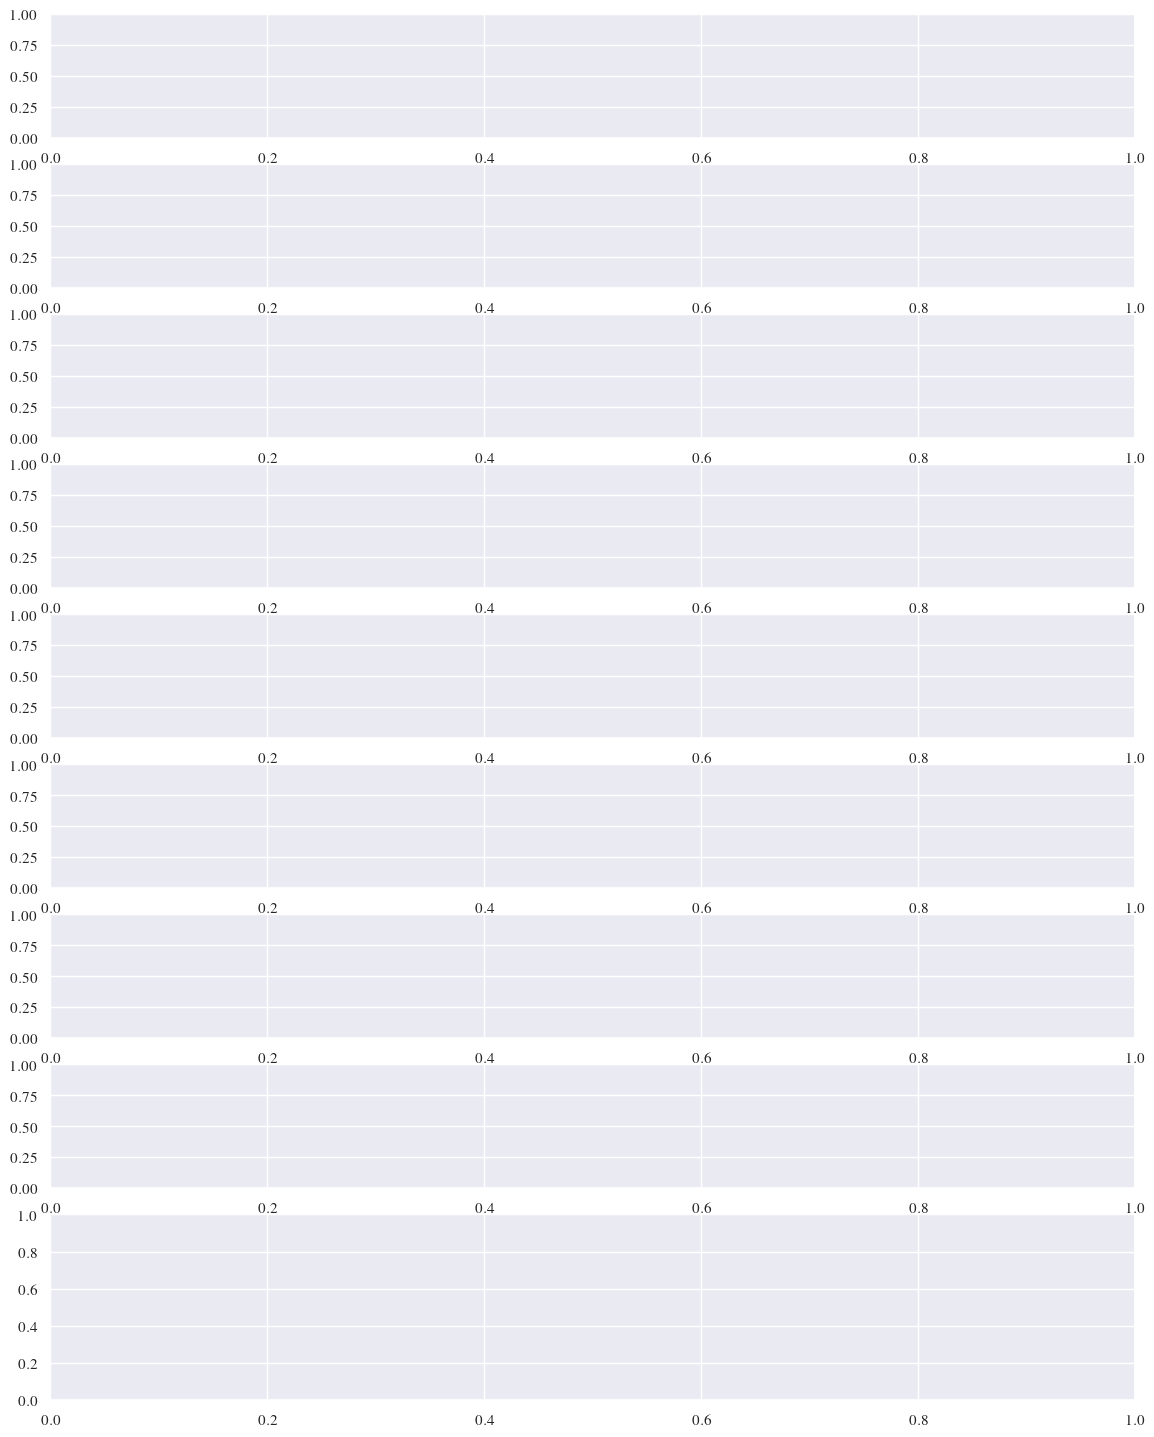

In [47]:
import matplotlib.cm as cm

fig, axis = plt.subplots(9, 1, figsize=(14, 2 * 9), height_ratios=[1] * 8 + [1.5], dpi=100)
palette = {
    "mobilenetv3": "#0C5DA5",
    "convnext": "#00B945",
    "efficientnet": "#FF9500",
    "vit": "#FF2C00",
    "resnet": "#845B97",
    "swin": "#474747",
}
sortby = "error_diff_mean" # used in the paper
# sortby = 'params'
# sortby = 'error_min'
# sortby = ['base_arch', 'params']
for i, ((gname, group), ax) in enumerate(zip(df.groupby("distortion"), axis)):
    group = group.sort_values(by=sortby)
    if gname == 'Contrast' or gname == 'Grid' or gname == 'Rescale':
        base_factor = 1.0
        palette = 'seismic'
    elif gname == 'JPEG':
        base_factor = 100
        palette = 'Reds'
    else:
        base_factor = 0
        palette = 'Reds'
    alpha = 0.8
    scatter = sns.scatterplot(
        ax=ax,
        data=group,
        x="model_name",
        y="error_diff",
        hue="factor",
        style="base_arch",
        legend=False,
        palette=palette,
        alpha=alpha
    )
    sns.scatterplot(
        ax=ax,
        data=group[group["factor"] == base_factor],
        x="model_name",
        y="error_diff",
        hue="factor",
        style="base_arch",
        legend=False,
        palette=['yellow'],
        alpha=alpha
    )

    # Add colorbar next to each plot
    norm = plt.Normalize(df['factor'].min(), df['factor'].max())
    sm = plt.cm.ScalarMappable(cmap=palette, norm=norm)
    sm.set_array([])
    fig.colorbar(sm, ax=ax)

    ax.set_title(gname)
    ax.set_ylabel("Error")
    ax.set_yticks([0, 0.5, 1.0])
    if i < len(axis) - 1:
        ax.set_xticklabels([])
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Model Name")
        ax.tick_params(axis="x", rotation=90)
    ax.set_ylim(-0.01, 1)

plt.show()

# ... rest of your code ...


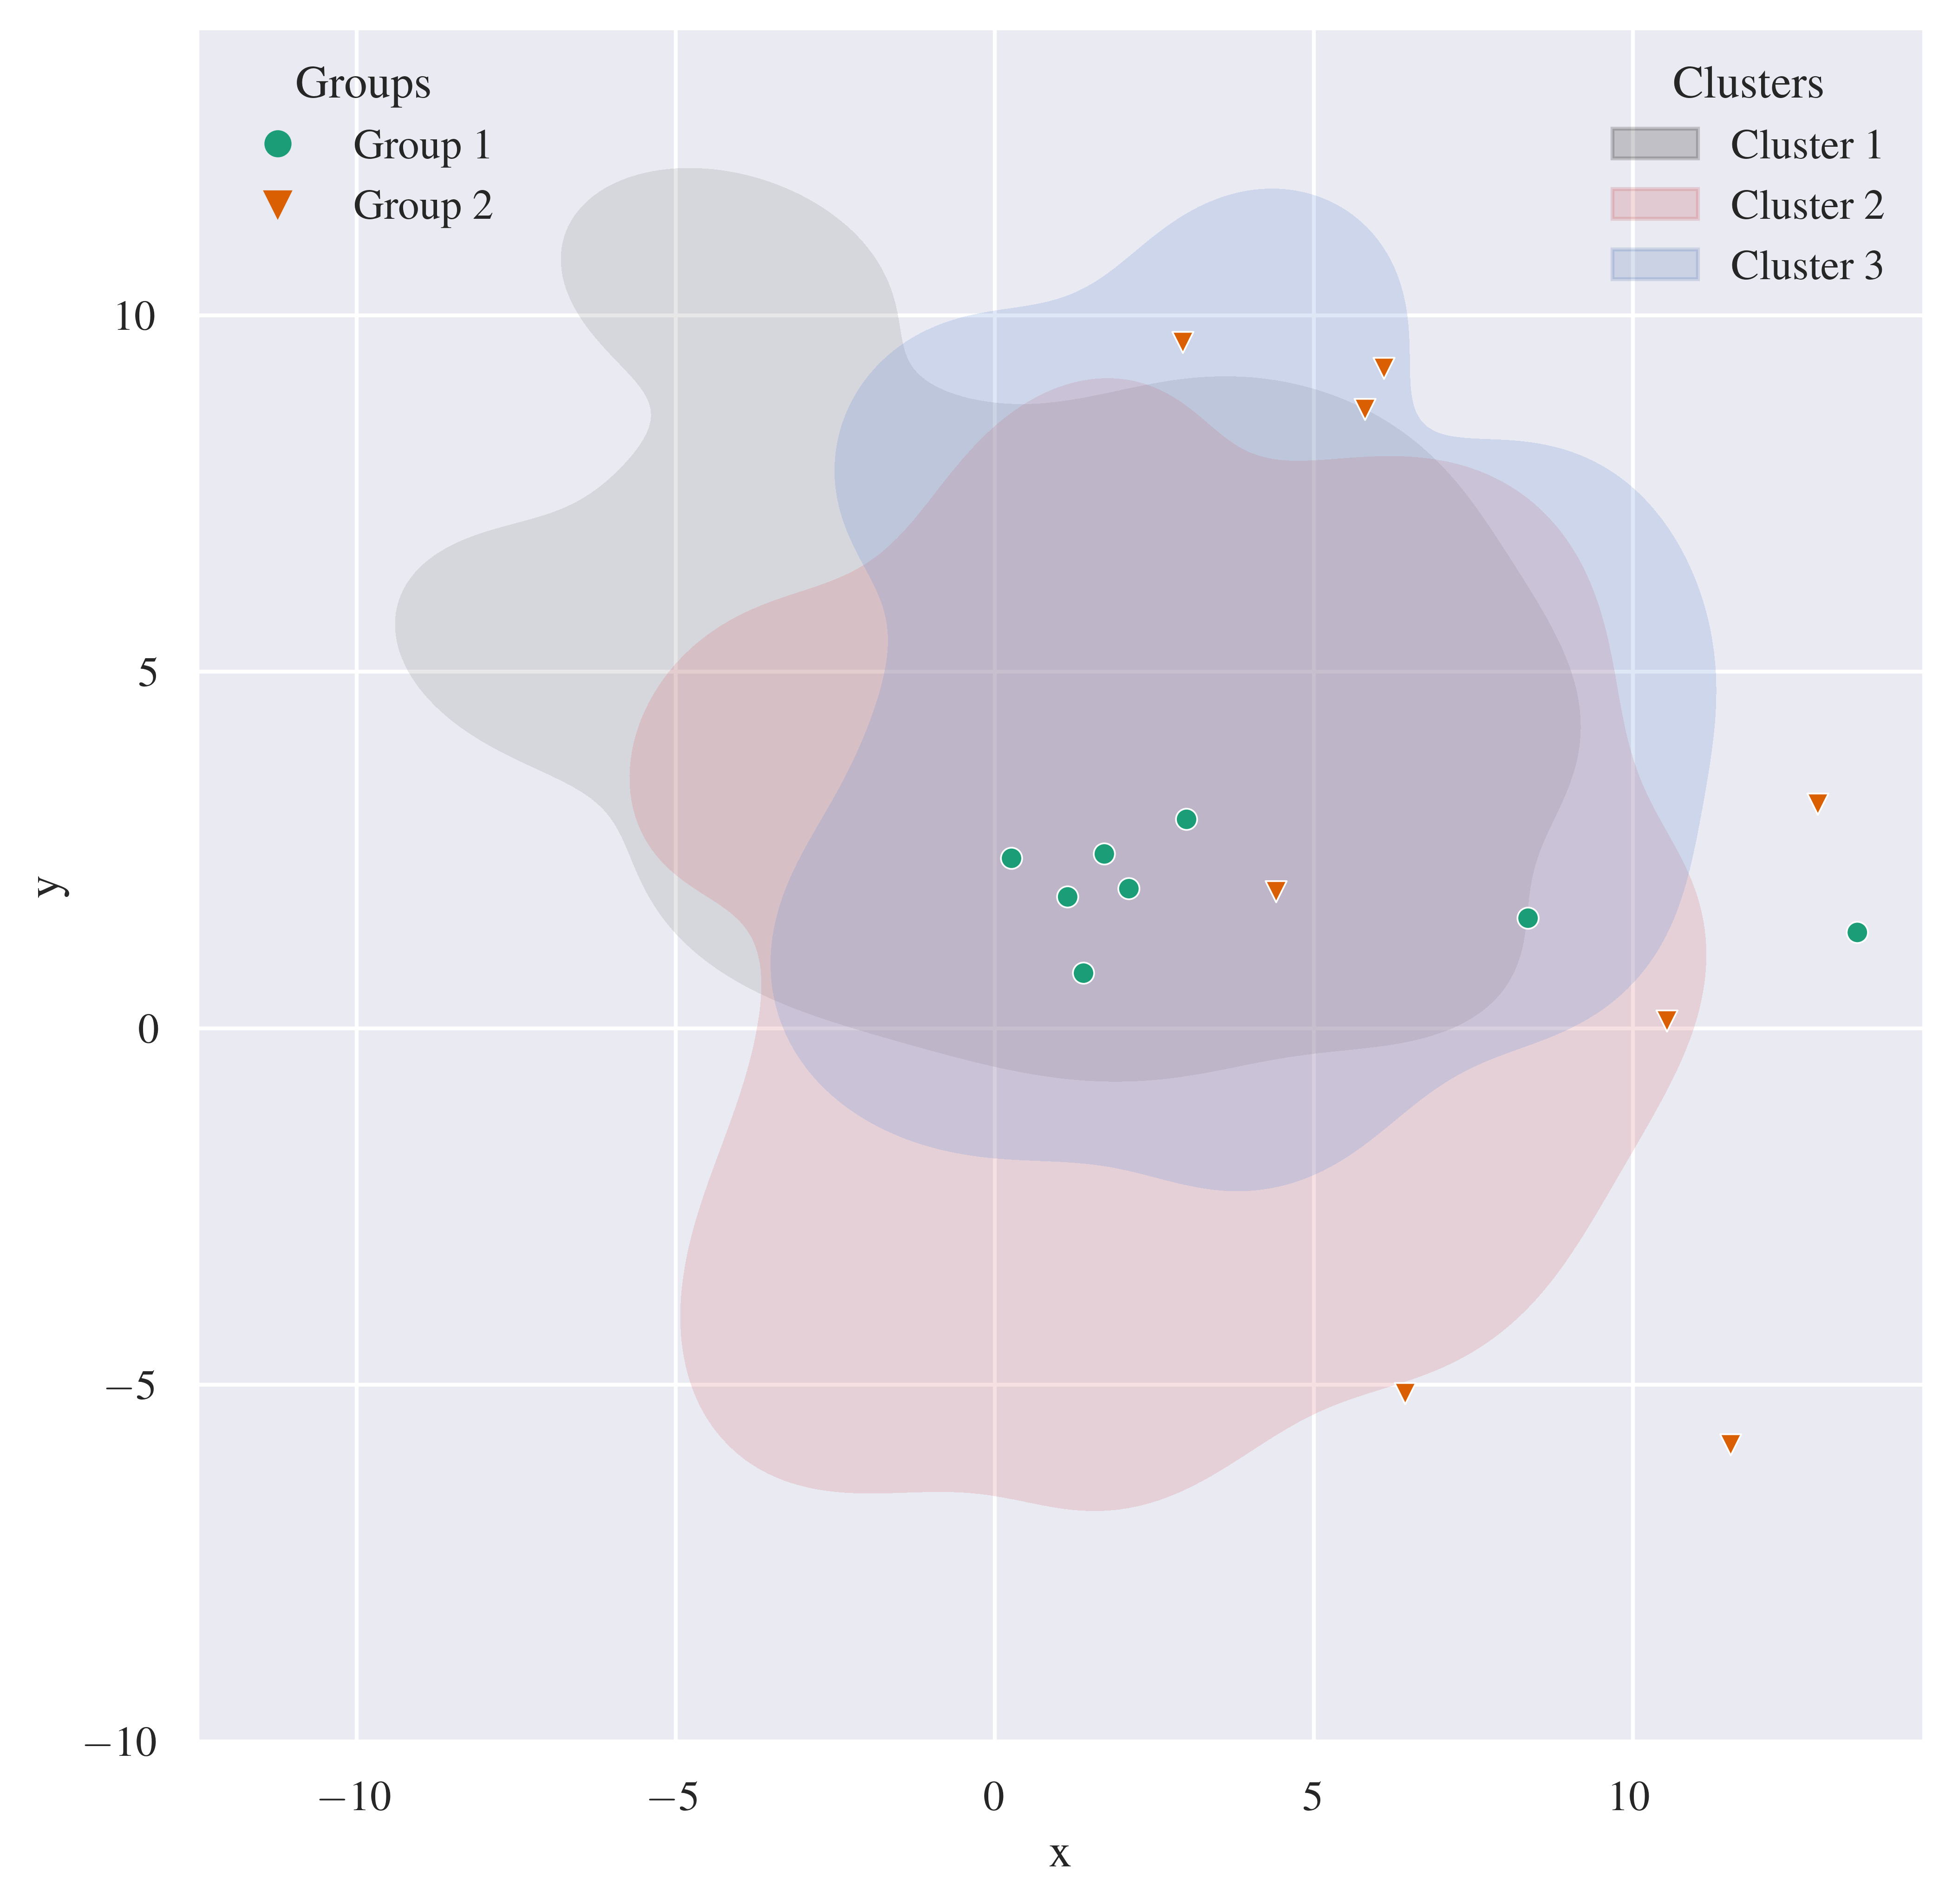

In [24]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# We will need to access some of these matplotlib classes directly
from matplotlib.lines import Line2D # For points and lines
from matplotlib.patches import Patch # For KDE and other plots
from matplotlib.legend import Legend

from matplotlib import cm

# Initialise random number generator
rng = np.random.default_rng(seed=42)

# Generate sample of 25 numbers
n = 25
clusters = []

for c in range(0,3):
    
    # Crude way to get different distributions
    # for each cluster
    p = rng.integers(low=1, high=6, size=4)
    
    df = pd.DataFrame({
        'x': rng.normal(p[0], p[1], n),
        'y': rng.normal(p[2], p[3], n),
        'name': f"Cluster {c+1}"
    })
    clusters.append(df)

# Flatten to a single data frame
clusters = pd.concat(clusters)

# Now do the same for data to feed into
# the second (scatter) plot... 
n = 8
points = []

for c in range(0,2):
    
    p = rng.integers(low=1, high=6, size=4)
    
    df = pd.DataFrame({
        'x': rng.normal(p[0], p[1], n),
        'y': rng.normal(p[2], p[3], n),
        'name': f"Group {c+1}"
    })
    points.append(df)

points = pd.concat(points)

# And create the figure
f, ax = plt.subplots(figsize=(8,8))

# The KDE-plot generates a Legend 'as usual'
k = sns.kdeplot(
    data=clusters,
    x='x', y='y',
    hue='name',
    shade=True,
    thresh=0.05,
    n_levels=2,
    alpha=0.2,
    ax=ax,
)

# Notice that we access this legend via the
# axis to turn off the frame, set the title, 
# and adjust the patch alpha level so that
# it closely matches the alpha of the KDE-plot
ax.get_legend().set_frame_on(False)
ax.get_legend().set_title("Clusters")
for lh in ax.get_legend().get_patches(): 
    lh.set_alpha(0.2)

# You would probably want to sort your data 
# frame or set the hue and style order in order
# to ensure consistency for your own application
# but this works for demonstration purposes
groups  = points.name.unique()
markers = ['o', 'v', 's', 'X', 'D', '<', '>']
colors  = cm.get_cmap('Dark2').colors

# Generate the scatterplot: notice that Legend is
# off (otherwise this legend would overwrite the 
# first one) and that we're setting the hue, style,
# markers, and palette using the 'name' parameter 
# from the data frame and the number of groups in 
# the data.
p = sns.scatterplot(
    data=points,
    x="x",
    y="y",
    hue='name',
    style='name',
    markers=markers[:len(groups)],
    palette=colors[:len(groups)],
    legend=False,
    s=30,
    alpha=1.0
)

# Here's the 'magic' -- we use zip to link together 
# the group name, the color, and the marker style. You
# *cannot* retreive the marker style from the scatterplot
# since that information is lost when rendered as a 
# PathCollection (as far as I can tell). Anyway, this allows
# us to loop over each group in the second data frame and 
# generate a 'fake' Line2D plot (with zero elements and no
# line-width in our case) that we can add to the legend. If
# you were overlaying a line plot or a second plot that uses
# patches you'd have to tweak this accordingly.
patches = []
for x in zip(groups, colors[:len(groups)], markers[:len(groups)]):
    patches.append(Line2D([0],[0], linewidth=0.0, linestyle='', 
                   color=x[1], markerfacecolor=x[1],
                   marker=x[2], label=x[0], alpha=1.0))

# And add these patches (with their group labels) to the new
# legend item and place it on the plot.
leg = Legend(ax, patches, labels=groups, 
             loc='upper left', frameon=False, title='Groups')
ax.add_artist(leg);

# Done
plt.show()

AttributeError: 'GrouperView' object has no attribute 'join'

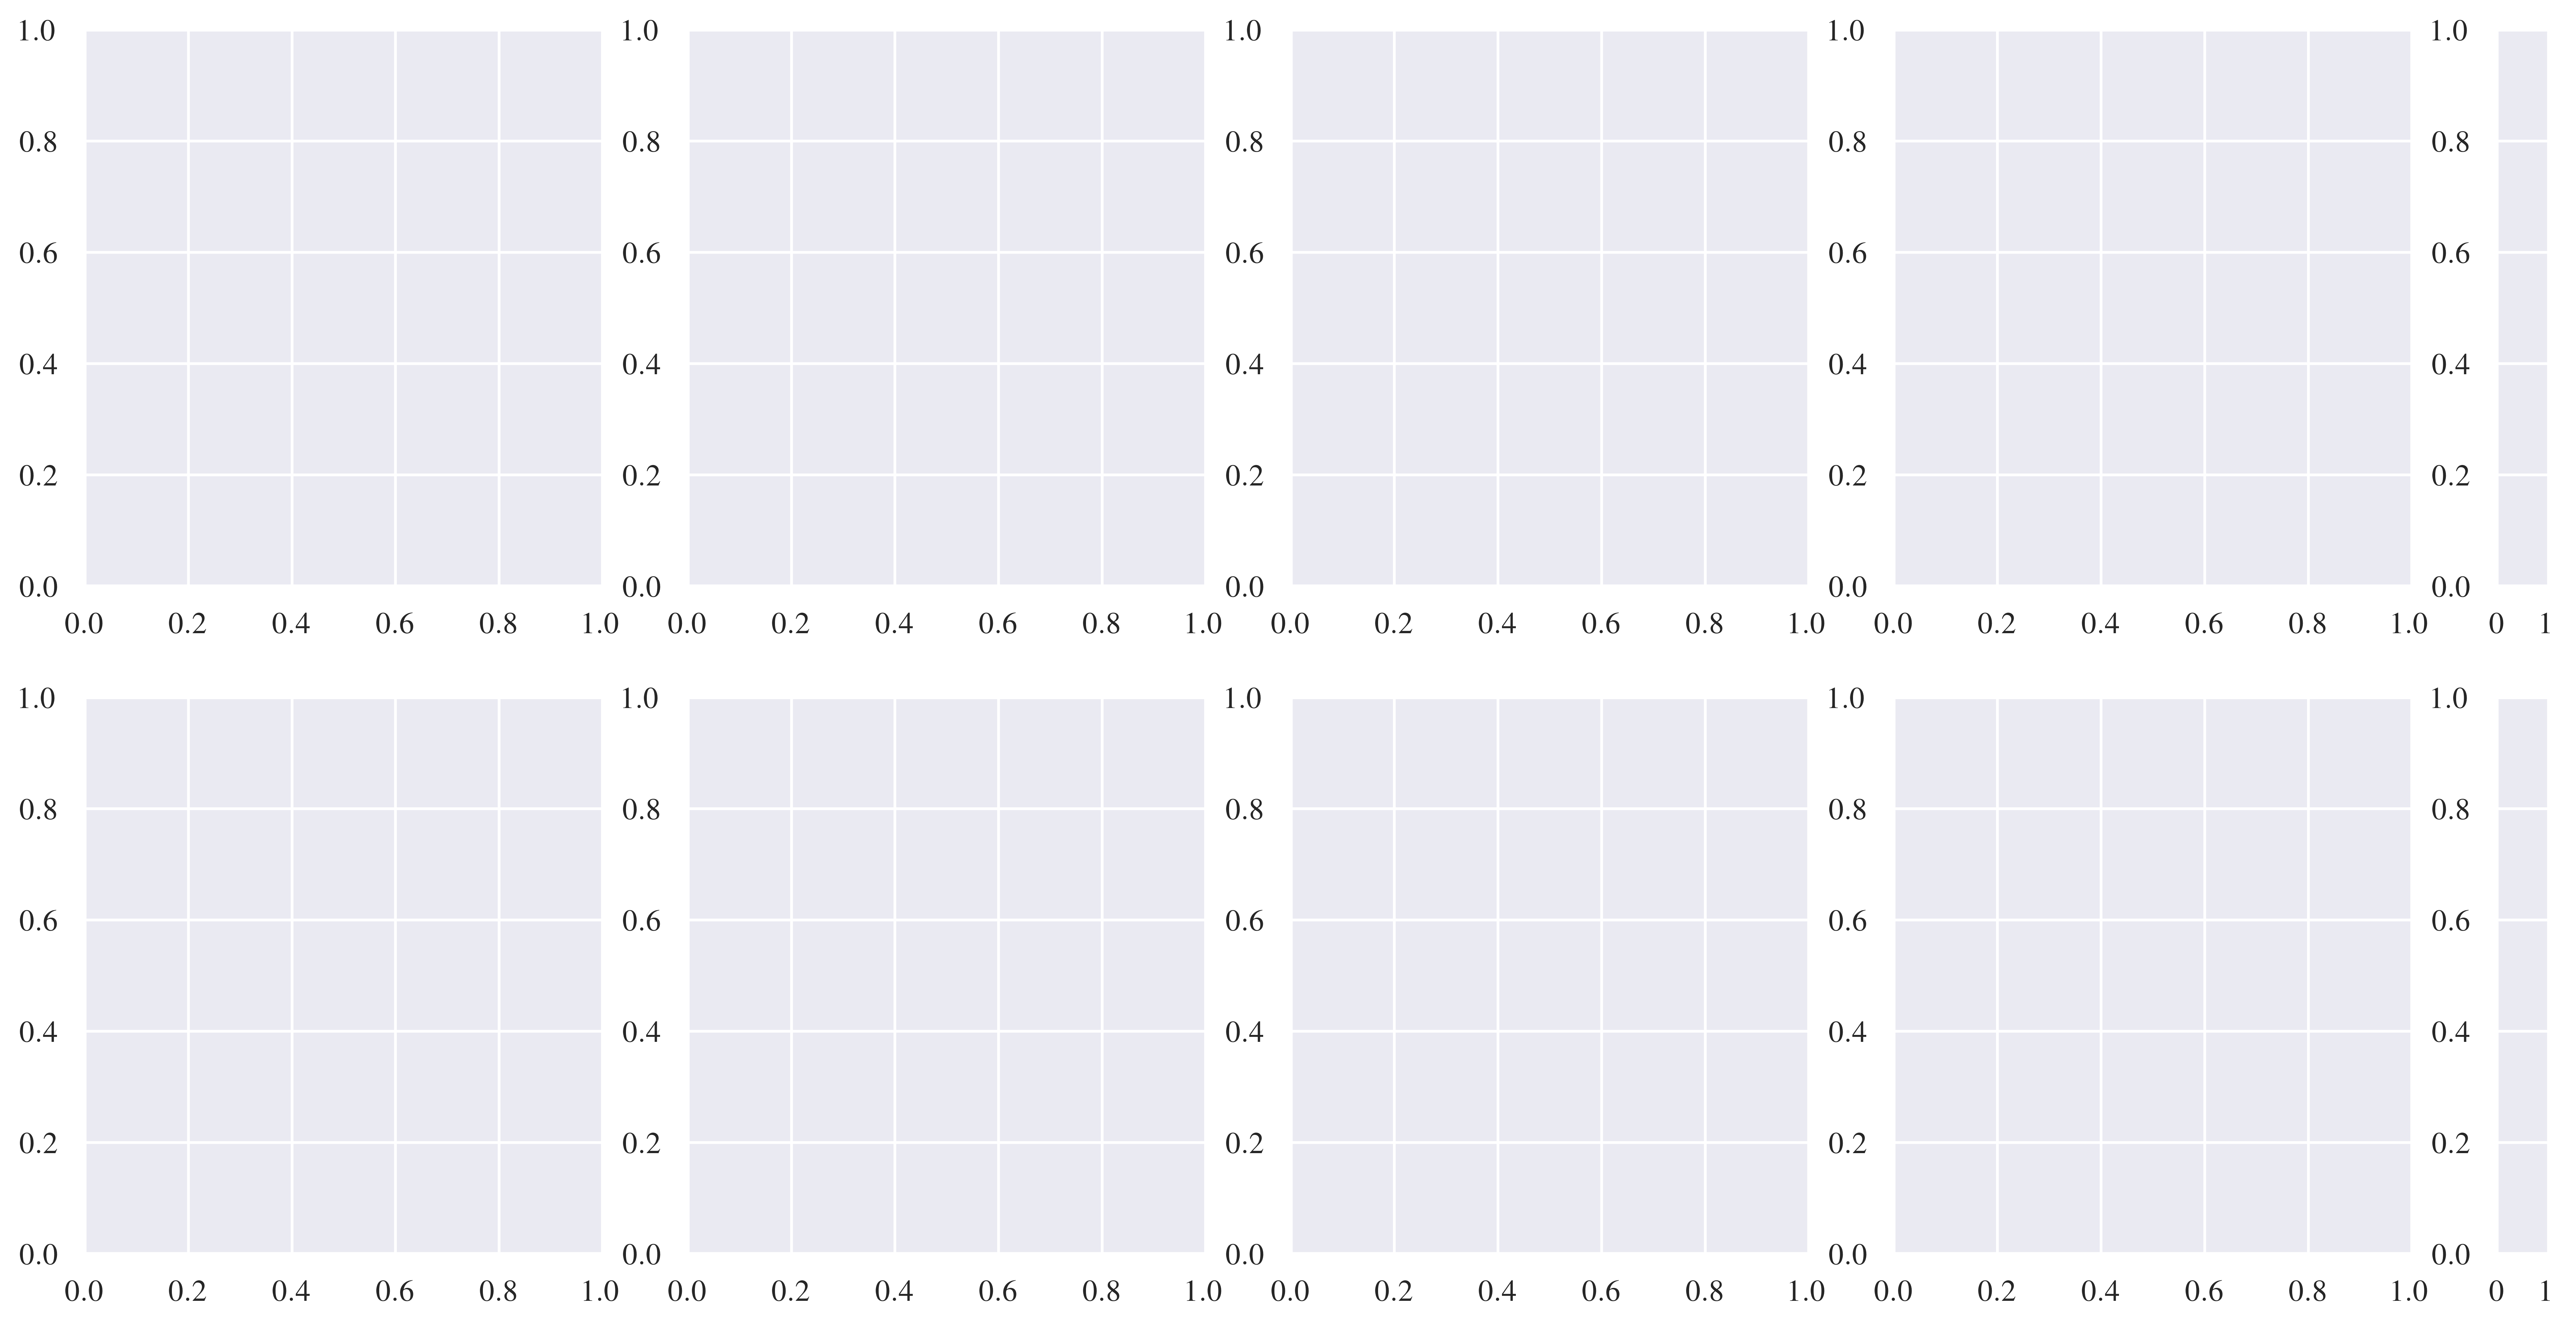

In [14]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

MAPPING_DICT = {"P": 0, "A": 1, "C": 2, "S": 3}
l2_distances = {"P": np.random.rand(10, 10), "A": np.random.rand(10, 10), "C": np.random.rand(10, 10),
                "S": np.random.rand(10, 10)}

fig, axes = plt.subplots(nrows=2, ncols=5, sharex=False, sharey=False, figsize=(16, 8),
                         gridspec_kw={'width_ratios': [10, 10, 10, 10, 1]})
shax = axes[0, 0].get_shared_x_axes()
shay = axes[0, 0].get_shared_y_axes()
for ax in axes[:, :-1].ravel():
    shax.join(axes[0, 0], ax)
    shay.join(axes[0, 0], ax)
for row in range(axes.shape[0]):
    for env_name in l2_distances:
        l2_dist_matrix = l2_distances[env_name]
        print(env_name, l2_dist_matrix.shape)
        cbar_flag = True if MAPPING_DICT[env_name] == 3 else False
        sns.heatmap(l2_dist_matrix, ax=axes[row, MAPPING_DICT[env_name]], linewidths=0.2, square=True,
                    cbar=cbar_flag, cbar_ax=axes[row, -1], cmap="Blues", xticklabels=False, yticklabels=False,
                    robust=True)
plt.show()

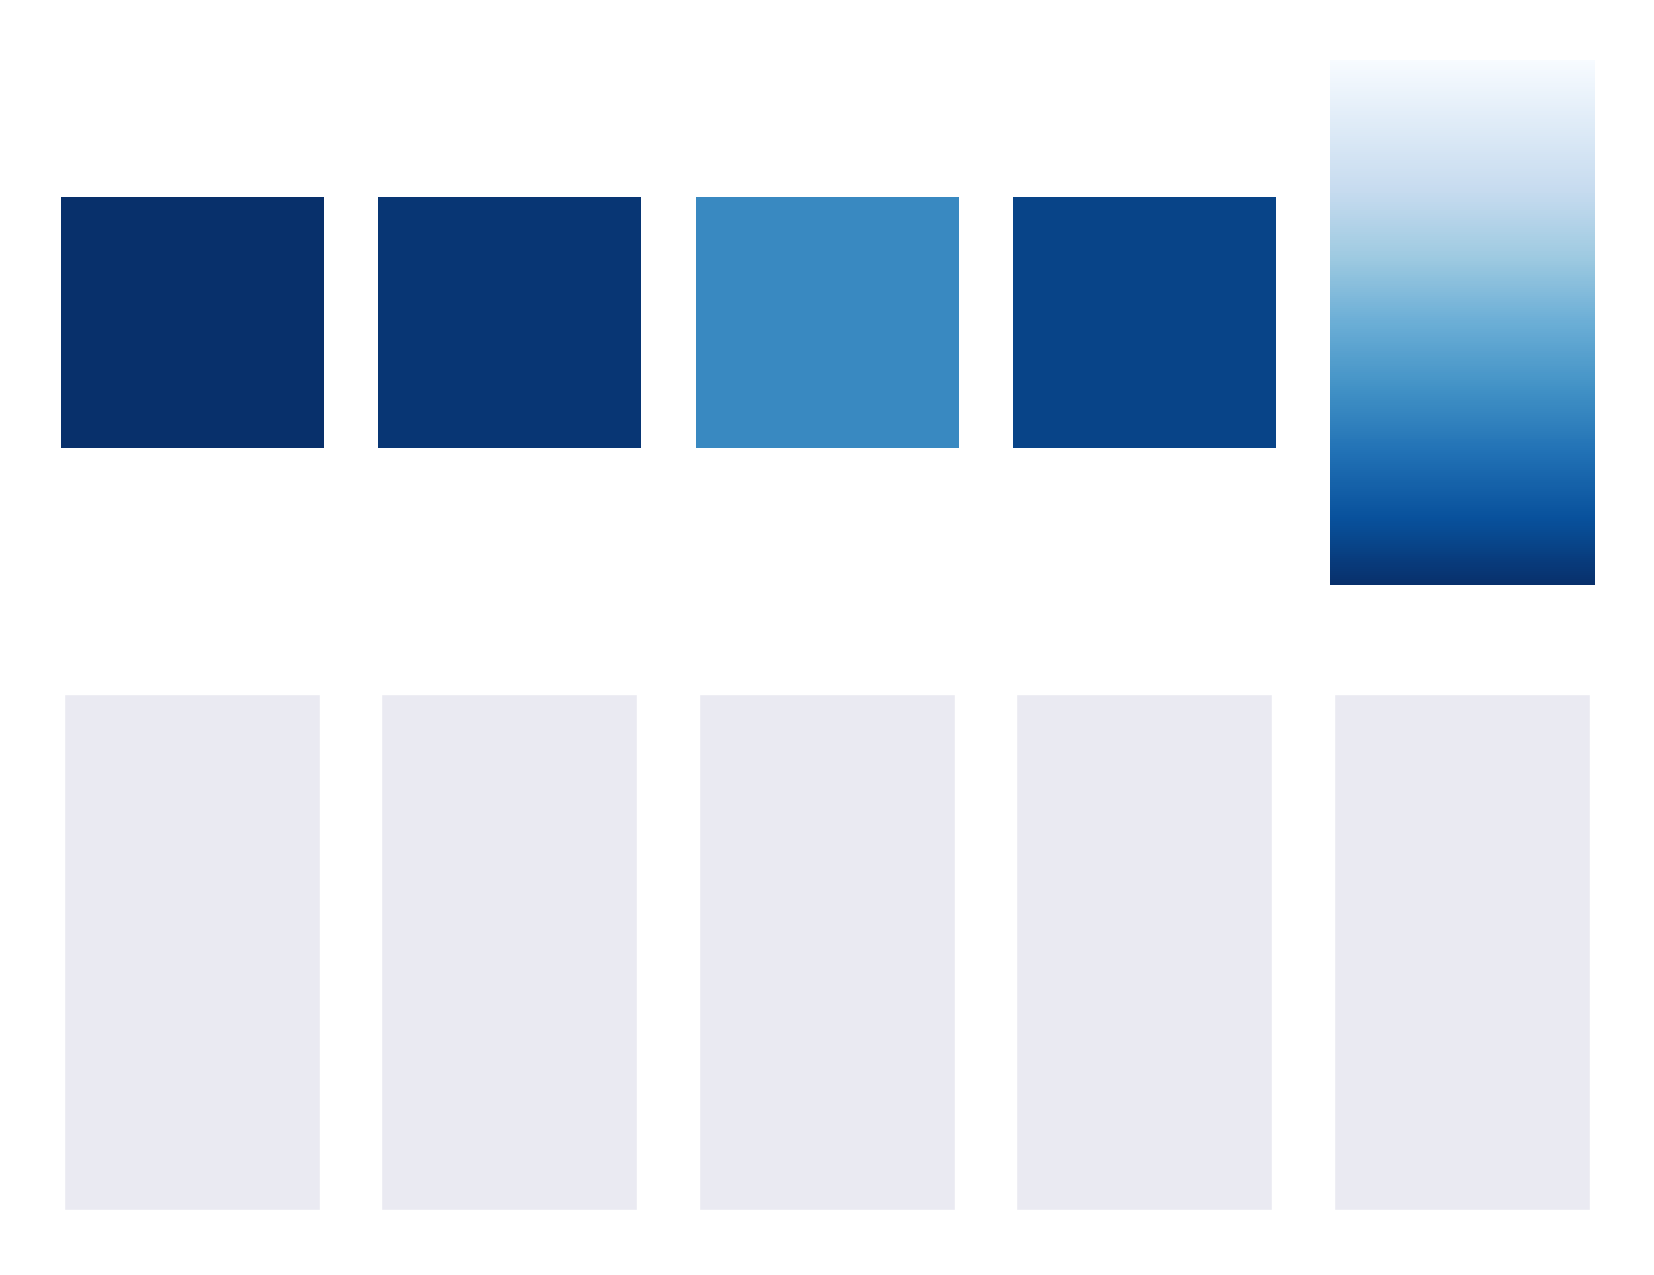

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

MAPPING_DICT = {"P": 0, "A": 1, "C": 2, "S": 3}

fig, axes = plt.subplots(2,5, sharex=True, sharey=True)
for env_name in l2_distances:
    l2_dist_matrix = l2_distances[env_name]
    cbar_flag = True if MAPPING_DICT[env_name]==3 else False
    sns.heatmap(l2_dist_matrix, ax=axes[0, MAPPING_DICT[env_name]], linewidths=0.2, square=True, cbar=cbar_flag, cbar_ax=axes[0,4], cmap="Blues", xticklabels=False, yticklabels=False, robust=True)
